In [ ]:
!git clone https://github.com/lucidrains/denoising-diffusion-pytorch.git

Cloning into 'denoising-diffusion-pytorch'...
remote: Enumerating objects: 1363, done.
remote: Counting objects: 100% (553/553), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 1363 (delta 477), reused 460 (delta 433), pack-reused 810
Receiving objects: 100% (1363/1363), 2.44 MiB | 41.01 MiB/s, done.
Resolving deltas: 100% (995/995), done.


In [ ]:
!pip install einops
!pip install torchdiffeq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.7 MB/s eta 0:00:00


In [ ]:
import os
import shutil

# Source folder path
source_folder = 'denoising-diffusion-pytorch'

# Get a list of all files in the source folder
files = os.listdir(source_folder)

# Move each file to the current folder
for file in files:
    # Construct the source file path
    source_file = os.path.join(source_folder, file)
    # Move the file to the current folder
    shutil.move(source_file, file)

!rm -r denoising-diffusion-pytorch
!rm -r sample_data

In [ ]:
!pip install denoising_diffusion_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 27.8 MB/s eta 0:00:00


In [ ]:
from functools import wraps
from packaging import version
from collections import namedtuple

import torch
import torch.nn as nn
from torch import einsum
import torch.nn.functional as F

from einops import rearrange

# constants

AttentionConfig = namedtuple('AttentionConfig', ['enable_flash', 'enable_math', 'enable_mem_efficient'])

# helpers

def exists(val):
    return val is not None

def once(fn):
    called = False
    @wraps(fn)
    def inner(x):
        nonlocal called
        if called:
            return
        called = True
        return fn(x)
    return inner

print_once = once(print)

# main class

class Attend(nn.Module):
    def __init__(
        self,
        dropout = 0.,
        flash = False
    ):
        super().__init__()
        self.dropout = dropout
        self.attn_dropout = nn.Dropout(dropout)

        self.flash = flash
        assert not (flash and version.parse(torch.__version__) < version.parse('2.0.0')), 'in order to use flash attention, you must be using pytorch 2.0 or above'

        # determine efficient attention configs for cuda and cpu
        self.cpu_config = AttentionConfig(True, True, True)
        self.cuda_config = None

        if not torch.cuda.is_available() or not flash:
            return

        device_properties = torch.cuda.get_device_properties(torch.device('cuda'))

        if device_properties.major == 8 and device_properties.minor == 0:
            print_once('A100 GPU detected, using flash attention if input tensor is on cuda')
            self.cuda_config = AttentionConfig(True, False, False)
        else:
            print_once('Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda')
            self.cuda_config = AttentionConfig(False, True, True)

    def flash_attn(self, q, k, v):
        _, heads, q_len, _, k_len, is_cuda, device = *q.shape, k.shape[-2], q.is_cuda, q.device

        q, k, v = map(lambda t: t.contiguous(), (q, k, v))

        # Check if there is a compatible device for flash attention
        config = self.cuda_config if is_cuda else self.cpu_config

        # pytorch 2.0 flash attn: q, k, v, mask, dropout, causal, softmax_scale
        with torch.backends.cuda.sdp_kernel(**config._asdict()):
            out = F.scaled_dot_product_attention(
                q, k, v,
                dropout_p = self.dropout if self.training else 0.
            )

        return out

    def forward(self, q, k, v):
        """
        einstein notation
        b - batch
        h - heads
        n, i, j - sequence length (base sequence length, source, target)
        d - feature dimension
        """

        q_len, k_len, device = q.shape[-2], k.shape[-2], q.device

        if self.flash:
            return self.flash_attn(q, k, v)

        scale = q.shape[-1] ** -0.5

        # similarity
        sim = einsum(f"b h i d, b h j d -> b h i j", q, k) * scale

        # attention
        attn = sim.softmax(dim = -1)
        attn = self.attn_dropout(attn)

        # aggregate values
        out = einsum(f"b h i j, b h j d -> b h i d", attn, v)

        return out

In [ ]:
import matplotlib.pyplot as plt
import imageio
import einops
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint, odeint_adjoint


MAX_NUM_STEPS = 1000

def sinusoidal_embedding(n, d):
    """
    Generates sinusoidal embeddings for conditioning the model on the current time step.

    Args:
        n (int): The number of time steps.
        d (int): The dimensionality of the embedding.

    Returns:
        torch.Tensor: A tensor of shape (n, d) representing the sinusoidal embeddings.

    """
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:, ::2] = torch.sin(t * wk[:, ::2])
    embedding[:, 1::2] = torch.cos(t * wk[:, ::2])

    return embedding


def _make_te(self, dim_in, dim_out):
    """
    Utility function that creates a one-layer MLP used for mapping a positional embedding.

    Args:
        dim_in (int): The input dimensionality of the MLP.
        dim_out (int): The output dimensionality of the MLP.

    Returns:
        torch.nn.Sequential: A one-layer MLP module.

    """
    return nn.Sequential(
        nn.Linear(dim_in, dim_out),
        nn.SiLU(),
        nn.Linear(dim_out, dim_out)
    )


def get_nonlinearity(name):
    """Helper function to get non linearity module, choose from relu/softplus/swish/lrelu"""
    if name == "relu":
        return nn.ReLU(inplace=True)
    elif name == "softplus":
        return nn.Softplus()
    elif name == "swish":
        return Swish(inplace=True)
    elif name == "lrelu":
        return nn.LeakyReLU()


class Swish(nn.Module):
    def __init__(self, inplace=False):
        """The Swish non linearity function"""
        super().__init__()
        self.inplace = True

    def forward(self, x):
        if self.inplace:
            x.mul_(F.sigmoid(x))
            return x
        else:
            return x * F.sigmoid(x)


class RandomOrLearnedSinusoidalPosEmb(nn.Module):
    """ following @crowsonkb 's lead with random (learned optional) sinusoidal pos emb """
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim, is_random = False):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim), requires_grad = not is_random)

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered


class RMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        return F.normalize(x, dim = 1) * self.g * (x.shape[1] ** 0.5)


class Attention(nn.Module):
    def __init__(
        self,
        dim,
        heads = 4,
        dim_head = 32,
        flash = False
    ):
        super().__init__()
        self.heads = heads
        hidden_dim = dim_head * heads

        self.norm = RMSNorm(dim)
        self.attend = Attend(flash = flash)

        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape

        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h (x y) c', h = self.heads), qkv)

        out = self.attend(q, k, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)

        return self.to_out(out)


# class Block(nn.Module):
#     def __init__(self, dim, dim_out, groups = 8):
#         super().__init__()
#         self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
#         # Divides the channels into groups and normalises them
#         self.norm = nn.GroupNorm(groups, dim_out)
#         self.act = nn.SiLU()

#     def forward(self, x, scale_shift = None):
#         x = self.proj(x)
#         x = self.norm(x)

#         # Scales and shifts the output of the normalisation
#         # This allos for additional conditioning of the output
#         if exists(scale_shift):
#             scale, shift = scale_shift
#             x = x * (scale + 1) + shift

#         x = self.act(x)
#         return x


# class ResnetBlock(nn.Module):
#     def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 2):
#         super().__init__()
#         self.mlp = nn.Sequential(
#             nn.SiLU(),
#             nn.Linear(time_emb_dim, dim_out * 2)
#         ) if exists(time_emb_dim) else None

#         self.block1 = Block(dim, dim_out, groups = groups)
#         self.block2 = Block(dim_out, dim_out, groups = groups)
#         # 1x1 convolution used for the residual connection
#         self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

#     def forward(self, x, time_emb = None):

#         scale_shift = None
#         if exists(self.mlp) and exists(time_emb):
#             # Use MLP to compute the scale_shift
#             time_emb = self.mlp(time_emb)
#             time_emb = rearrange(time_emb, 'b c -> b c 1 1')
#             scale_shift = time_emb.chunk(2, dim = 1)

#         # R(x) = H(x) - x => H(x) = R(x) + x
#         h = self.block1(x, scale_shift = scale_shift)
#         h = self.block2(h)

#         # h is the output of the sequence of transformations applied to the input x
#         # self.res_conv(x) is the original input x passed through a 1x1 conv (just to match dims)
#         return h + self.res_conv(x)


class InitialVelocity(nn.Module):
    def __init__(self, nf, non_linearity="relu"):
        super(InitialVelocity, self).__init__()

        self.norm1 = nn.InstanceNorm2d(nf)
        #self.norm1 = nn.InstanceNorm2d(1)
        #self.conv1 = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1)
        # For 1 channel images (?)
        self.conv1 = nn.Conv2d(3, nf, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.InstanceNorm2d(nf)
        #self.conv2 = nn.Conv2d(nf, nf, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(nf, nf*2, kernel_size=1, stride=1, padding=0)

        self.non_linearity = get_nonlinearity(non_linearity)

    def forward(self, x0):
        out = self.norm1(x0)
        out = self.conv1(out)
        out = self.non_linearity(out)
        out = self.norm2(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        return out #torch.cat((x0, out), dim=1)


class ODEBlock(nn.Module):
    def __init__(self, odefunc, tol=1e-3, adjoint=False):
        """
        Code adapted from https://github.com/EmilienDupont/augmented-neural-odes
        Utility class that wraps odeint and odeint_adjoint.

        Wrapper that takes the function f (given by ConvSODEFunc) and solves the
        ODE using that function. ConvSODEFunc defines the actual transformation of
        the datam while the ODE block is responsible for solving the ODE defined
        by that transformation.

        Args:
            odefunc (nn.Module): the module to be evaluated
            tol (float): tolerance for the ODE solver
            adjoint (bool): whether to use the adjoint method for gradient calculation
        """
        super(ODEBlock, self).__init__()
        self.adjoint = adjoint
        self.odefunc = odefunc
        self.tol = tol

    def forward(self, x, time_emb, eval_times=None, method="rk4"):
        # Forward pass corresponds to solving ODE, so reset number of function
        # evaluations counter
        self.odefunc.nfe = 0

        if eval_times is None:
            integration_time = torch.tensor([0, 1]).float().type_as(x)
        else:
            integration_time = eval_times.type_as(x)

        if self.adjoint:
            out = odeint_adjoint(
                lambda t, x: self.odefunc(t, x, time_emb=time_emb),
                x,
                integration_time,
                rtol=self.tol,
                atol=self.tol,
                method=method,
                options={"max_num_steps": MAX_NUM_STEPS},
            )
        else:
            out = odeint(
                lambda t, x: self.odefunc(t, x, time_emb=time_emb),
                x,
                integration_time,
                rtol=self.tol,
                atol=self.tol,
                method=method,
                options={"max_num_steps": MAX_NUM_STEPS},
            )

        if eval_times is None:
            return out[1]  # out[1][:int(len(x)/2)]  Return only final time
        else:
            return out

    def trajectory(self, x, timesteps):
        integration_time = torch.linspace(0.0, 1.0, timesteps)
        return self.forward(x, eval_times=integration_time)


class Conv2dTime(nn.Conv2d):
    def __init__(self, in_channels, *args, **kwargs):
        """
        Code adapted from https://github.com/EmilienDupont/augmented-neural-odes
        Conv2d module where time gets concatenated as a feature map.
        Makes ODE func aware of the current time step.
        """
        super(Conv2dTime, self).__init__(in_channels + 1, *args, **kwargs)

    def forward(self, t, x):
        # Shape (batch_size, 1, height, width)
        t_img = torch.ones_like(x[:, :1, :, :]) * t
        # Shape (batch_size, channels + 1, height, width)
        t_and_x = torch.cat([t_img, x], 1)
        return super(Conv2dTime, self).forward(t_and_x)


# class ConvSODEFunc(nn.Module):
#     def __init__(self, nf, time_dependent=False, non_linearity="relu"):
#         """
#         Block for ConvSODEUNet. Designed to be used as the function f that defines
#         the derivative in an ODE of the form dz/dt = f(t, z). This function represents
#         how the hidden state z changes with respect to the continuous time variable t.

#         ConvSODE defines the actual transformation of the datam while the ODE
#         block is responsible for solving the ODE defined by that transformation.

#         Args:
#             nf (int): number of filters for the conv layers
#             time_dependent (bool): whether to concat the time as a feature map before the convs
#             non_linearity (str): which non_linearity to use (for options see get_nonlinearity)
#         """
#         super(ConvSODEFunc, self).__init__()
#         self.time_dependent = time_dependent
#         self.nfe = 0  # Number of function evaluations

#         if time_dependent:
#             self.norm1 = nn.InstanceNorm2d(nf)
#             self.conv1 = Conv2dTime(nf, nf, kernel_size=3, stride=1, padding=1)
#             self.norm2 = nn.InstanceNorm2d(nf)
#             self.conv2 = Conv2dTime(nf, nf, kernel_size=3, stride=1, padding=1)
#         else:
#             self.norm1 = nn.InstanceNorm2d(nf)
#             self.conv1 = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1)
#             self.norm2 = nn.InstanceNorm2d(nf)
#             # changed to kernel_size 1 with padding 0 instead of 1
#             self.conv2 = nn.Conv2d(nf, nf, kernel_size=1, stride=1, padding=0)

#         self.non_linearity = get_nonlinearity(non_linearity)

#     def forward(self, t, x):
#         cutoff = int(x.shape[1] / 2)  # int(len(x)/2)
#         # Typical in neural ODEs as they usually operate in anaugmented state space
#         z = x[:, :cutoff]
#         v = x[:, cutoff:]
#         into = torch.cat((z, v), dim=1)
#         self.nfe += 1
#         if self.time_dependent:
#             out = self.norm1(into)
#             out = self.conv1(t, into)
#             out = self.non_linearity(out)
#             out = self.norm2(out)
#             out = self.conv2(t, out)
#             out = self.non_linearity(out)
#         else:
#             out = self.norm1(into)
#             out = self.conv1(out)
#             out = self.non_linearity(out)
#             out = self.norm2(out)
#             out = self.conv2(out)
#             out = self.non_linearity(out)
#         return out


class ConvSODEFunc(nn.Module):
    def __init__(self, nf, time_dependent=False, non_linearity="relu",
                 time_emb_dim=None):
        """
        Block for ConvSODEUNet. Designed to be used as the function f that defines
        the derivative in an ODE of the form dz/dt = f(t, z). This function represents
        how the hidden state z changes with respect to the continuous time variable t.

        ConvSODE defines the actual transformation of the datam while the ODE
        block is responsible for solving the ODE defined by that transformation.

        Args:
            nf (int): number of filters for the conv layers
            time_dependent (bool): whether to concat the time as a feature map before the convs
            non_linearity (str): which non_linearity to use (for options see get_nonlinearity)
        """
        super(ConvSODEFunc, self).__init__()

        dim = nf
        dim_out = nf

        self.time_dependent = time_dependent
        self.nfe = 0  # Number of function evaluations

        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        if time_dependent:
            self.norm1 = nn.InstanceNorm2d(nf)
            self.conv1 = Conv2dTime(nf, nf, kernel_size=3, stride=1, padding=1)
            self.norm2 = nn.InstanceNorm2d(nf)
            self.conv2 = Conv2dTime(nf, nf, kernel_size=3, stride=1, padding=1)
        else:
            self.norm1 = nn.InstanceNorm2d(nf)
            self.conv1 = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1)
            self.norm2 = nn.InstanceNorm2d(nf)
            # changed to kernel_size 1 with padding 0 instead of 1 - WHY?
            # Working with kernel size 1 and padding 0
            self.conv2 = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1)

        # 1x1 convolution used for the residual connection
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

        self.non_linearity = get_nonlinearity(non_linearity)

    def forward(self, t, x, time_emb=None):
        scale_shift = None
        cutoff = int(x.shape[1] / 2)  # int(len(x)/2)
        # Typical in neural ODEs as they usually operate in anaugmented state space
        z = x[:, :cutoff]
        v = x[:, cutoff:]
        into = torch.cat((z, v), dim=1)
        self.nfe += 1

        if self.time_dependent:
            out = self.norm1(into)
            out = self.conv1(t, into)
            out = self.non_linearity(out)
            out = self.norm2(out)

            if exists(self.mlp) and exists(time_emb):
              time_emb = self.mlp(time_emb)
              time_emb = rearrange(time_emb, 'b c -> b c 1 1')
              scale_shift = time_emb.chunk(2, dim=1)
              scale, shift = scale_shift
              out = out * (scale + 1) + shift

            out = self.conv2(t, out)
            out = self.non_linearity(out)
        else:
            out = self.norm1(into)
            out = self.conv1(out)
            out = self.non_linearity(out)
            out = self.norm2(out)

            if exists(self.mlp) and exists(time_emb):
              time_emb = self.mlp(time_emb)
              time_emb = rearrange(time_emb, 'b c -> b c 1 1')
              scale_shift = time_emb.chunk(2, dim=1)
              scale, shift = scale_shift
              out = out * (scale + 1) + shift

            out = self.conv2(out)
            out = self.non_linearity(out)

        return out + self.res_conv(x)


# Second-order ODE UNet
class ConvSODEUNet(nn.Module):
    def __init__(
        self,
        n_steps=1000,
        time_emb_dim=256, # num_filters*16
        channels=3, # change to 3
        num_filters=16,
        out_dim=3, # change to 3
        time_dependent=False,
        non_linearity="softplus",
        tol=1e-3,
        adjoint=False,
        method="rk4"
    ):
        """
        ConvSODEUNet (Second order ODE UNet)
        Args:
            num_filters (int): number of filters for first conv layer
            output_dim (int): how many feature maps the network outputs
            time_dependent (bool): whether to concat the time as a feature map before the convs
            non_linearity (str): which non_linearity to use (for options see get_nonlinearity)
            tol (float): tolerance to be used for ODE solver
            adjoint (bool): whether to use the adjoint method to calculate the gradients
        """
        super(ConvSODEUNet, self).__init__()
        nf = num_filters
        self.method = method
        print(f"Solver: {method}")

        #################################################################
        self.channels = channels
        self.out_dim = out_dim
        self.random_or_learned_sinusoidal_cond = None
        self.self_condition = False
        #################################################################

        #################################################################
        self.attention_encoder2 = Attention(dim=nf*4)
        self.attention_encoder4 = Attention(dim=nf*16)

        self.attention_decoder1 = Attention(dim=nf*16)
        self.attention_decoder3 = Attention(dim=nf*4)
        #################################################################

        #################################################################
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)
        #################################################################
        self.initial_velocity = InitialVelocity(nf, non_linearity)

        ode_down1 = ConvSODEFunc(nf * 2, time_dependent, non_linearity) # 32
        self.odeblock_down1 = ODEBlock(ode_down1, tol=tol, adjoint=adjoint)
        self.conv_down1_2 = nn.Conv2d(nf * 2, nf * 4, 1, 1)

        ode_down2 = ConvSODEFunc(nf * 4, time_dependent, non_linearity) # 64
        self.odeblock_down2 = ODEBlock(ode_down2, tol=tol, adjoint=adjoint)
        self.conv_down2_3 = nn.Conv2d(nf * 4, nf * 8, 1, 1)

        ode_down3 = ConvSODEFunc(nf * 8, time_dependent, non_linearity) # 128
        self.odeblock_down3 = ODEBlock(ode_down3, tol=tol, adjoint=adjoint)
        self.conv_down3_4 = nn.Conv2d(nf * 8, nf * 16, 1, 1)

        ode_down4 = ConvSODEFunc(nf * 16, time_dependent, non_linearity) # 256
        self.odeblock_down4 = ODEBlock(ode_down4, tol=tol, adjoint=adjoint)
        self.conv_down4_embed = nn.Conv2d(nf * 16, nf * 32, 1, 1)

        ode_embed = ConvSODEFunc(nf * 32, time_dependent, non_linearity) # 512
        self.odeblock_embedding = ODEBlock(ode_embed, tol=tol, adjoint=adjoint)
        self.conv_up_embed_1 = nn.Conv2d(nf * 32 + nf * 16, nf * 16, 1, 1)

        ode_up1 = ConvSODEFunc(nf * 16, time_dependent, non_linearity) # 256
        self.odeblock_up1 = ODEBlock(ode_up1, tol=tol, adjoint=adjoint)
        self.conv_up1_2 = nn.Conv2d(nf * 16 + nf * 8, nf * 8, 1, 1)

        ode_up2 = ConvSODEFunc(nf * 8, time_dependent, non_linearity) # 128
        self.odeblock_up2 = ODEBlock(ode_up2, tol=tol, adjoint=adjoint)
        self.conv_up2_3 = nn.Conv2d(nf * 8 + nf * 4, nf * 4, 1, 1)

        ode_up3 = ConvSODEFunc(nf * 4, time_dependent, non_linearity) # 64
        self.odeblock_up3 = ODEBlock(ode_up3, tol=tol, adjoint=adjoint)
        self.conv_up3_4 = nn.Conv2d(nf * 4 + nf * 2, nf * 2, 1, 1)

        ode_up4 = ConvSODEFunc(nf * 2, time_dependent, non_linearity) # 32
        self.odeblock_up4 = ODEBlock(ode_up4, tol=tol, adjoint=adjoint)

        self.classifier = nn.Conv2d(nf * 2, out_dim, 1)

        self.non_linearity = get_nonlinearity(non_linearity)

    def forward(self, x, t, dummy=None):
      t = self.time_embed(t)
      n = len(x)
      x = self.initial_velocity(x)

      features1 = self.odeblock_down1(x, method=self.method, time_emb=t)
      x = self.non_linearity(self.conv_down1_2(features1))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      features2 = self.odeblock_down2(x, method=self.method, time_emb=t)
      features2 = self.attention_encoder2(features2)  # Attention in encoder
      x = self.non_linearity(self.conv_down2_3(features2))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      features3 = self.odeblock_down3(x, method=self.method, time_emb=t)
      x = self.non_linearity(self.conv_down3_4(features3))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      features4 = self.odeblock_down4(x, method=self.method, time_emb=t)
      features4 = self.attention_encoder4(features4) # Attention in encoder
      x = self.non_linearity(self.conv_down4_embed(features4))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      x = self.odeblock_embedding(x, method=self.method, time_emb=t)

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features4), dim=1)
      x = self.non_linearity(self.conv_up_embed_1(x))
      x = self.odeblock_up1(x,  method=self.method, time_emb=t)
      x = self.attention_decoder1(x)  # Attention in decoder

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features3), dim=1)
      x = self.non_linearity(self.conv_up1_2(x))
      x = self.odeblock_up2(x,  method=self.method, time_emb=t)

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features2), dim=1)
      x = self.non_linearity(self.conv_up2_3(x))
      x = self.odeblock_up3(x,  method=self.method, time_emb=t)
      x = self.odeblock_up3(x,  method=self.method, time_emb=t)

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features1), dim=1)
      x = self.non_linearity(self.conv_up3_4(x))
      x = self.odeblock_up4(x,  method=self.method, time_emb=t)

      pred = self.classifier(x)
      return pred


    def _make_te(self, dim_in, dim_out):
        """
        Utility function that creates a one-layer MLP which will be used to map a positional embedding.

        Args:
            dim_in (int): The input dimensionality.
            dim_out (int): The output dimensionality.

        Returns:
            nn.Sequential: The MLP model.

        """
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

# Attention might be placed wrong and it might have to be in the previous block

In [ ]:
# Second-order ODE UNet
class ConvSODEUNet(nn.Module):
    def __init__(
        self,
        n_steps=1000,
        time_emb_dim=256, # num_filters*16
        channels=3, # change to 3
        num_filters=16,
        out_dim=3, # change to 3
        time_dependent=False,
        non_linearity="softplus",
        tol=1e-3,
        adjoint=False,
        method="rk4"
    ):
        """
        ConvSODEUNet (Second order ODE UNet)
        Args:
            num_filters (int): number of filters for first conv layer
            output_dim (int): how many feature maps the network outputs
            time_dependent (bool): whether to concat the time as a feature map before the convs
            non_linearity (str): which non_linearity to use (for options see get_nonlinearity)
            tol (float): tolerance to be used for ODE solver
            adjoint (bool): whether to use the adjoint method to calculate the gradients
        """
        super(ConvSODEUNet, self).__init__()
        nf = num_filters
        self.method = method
        print(f"Solver: {method}")

        #################################################################
        self.channels = channels
        self.out_dim = out_dim
        self.random_or_learned_sinusoidal_cond = None
        self.self_condition = False
        #################################################################

        #################################################################
        self.attention_encoder4 = Attention(dim=nf*16)

        self.attention_decoder1 = Attention(dim=nf*16)
        #################################################################

        #################################################################
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)
        #################################################################
        self.initial_velocity = InitialVelocity(nf, non_linearity)

        ode_down1 = ConvSODEFunc(nf * 2, time_dependent, non_linearity) # 32
        self.odeblock_down1 = ODEBlock(ode_down1, tol=tol, adjoint=adjoint)
        self.conv_down1_2 = nn.Conv2d(nf * 2, nf * 4, 1, 1)

        ode_down2 = ConvSODEFunc(nf * 4, time_dependent, non_linearity) # 64
        self.odeblock_down2 = ODEBlock(ode_down2, tol=tol, adjoint=adjoint)
        self.conv_down2_3 = nn.Conv2d(nf * 4, nf * 8, 1, 1)

        ode_down3 = ConvSODEFunc(nf * 8, time_dependent, non_linearity) # 128
        self.odeblock_down3 = ODEBlock(ode_down3, tol=tol, adjoint=adjoint)
        self.conv_down3_4 = nn.Conv2d(nf * 8, nf * 16, 1, 1)

        ode_down4 = ConvSODEFunc(nf * 16, time_dependent, non_linearity) # 256
        self.odeblock_down4 = ODEBlock(ode_down4, tol=tol, adjoint=adjoint)
        self.conv_down4_embed = nn.Conv2d(nf * 16, nf * 32, 1, 1)

        ode_embed = ConvSODEFunc(nf * 32, time_dependent, non_linearity) # 512
        self.odeblock_embedding = ODEBlock(ode_embed, tol=tol, adjoint=adjoint)
        self.conv_up_embed_1 = nn.Conv2d(nf * 32 + nf * 16, nf * 16, 1, 1)

        ode_up1 = ConvSODEFunc(nf * 16, time_dependent, non_linearity) # 256
        self.odeblock_up1 = ODEBlock(ode_up1, tol=tol, adjoint=adjoint)
        self.conv_up1_2 = nn.Conv2d(nf * 16 + nf * 8, nf * 8, 1, 1)

        ode_up2 = ConvSODEFunc(nf * 8, time_dependent, non_linearity) # 128
        self.odeblock_up2 = ODEBlock(ode_up2, tol=tol, adjoint=adjoint)
        self.conv_up2_3 = nn.Conv2d(nf * 8 + nf * 4, nf * 4, 1, 1)

        ode_up3 = ConvSODEFunc(nf * 4, time_dependent, non_linearity) # 64
        self.odeblock_up3 = ODEBlock(ode_up3, tol=tol, adjoint=adjoint)
        self.conv_up3_4 = nn.Conv2d(nf * 4 + nf * 2, nf * 2, 1, 1)

        ode_up4 = ConvSODEFunc(nf * 2, time_dependent, non_linearity) # 32
        self.odeblock_up4 = ODEBlock(ode_up4, tol=tol, adjoint=adjoint)

        self.classifier = nn.Conv2d(nf * 2, out_dim, 1)

        self.non_linearity = get_nonlinearity(non_linearity)

    def forward(self, x, t, dummy=None):
      t = self.time_embed(t)
      x = self.initial_velocity(x)

      features1 = self.odeblock_down1(x, method=self.method, time_emb=t)
      x = self.non_linearity(self.conv_down1_2(features1))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      features2 = self.odeblock_down2(x, method=self.method, time_emb=t)
      x = self.non_linearity(self.conv_down2_3(features2))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      features3 = self.odeblock_down3(x, method=self.method, time_emb=t)
      x = self.non_linearity(self.conv_down3_4(features3))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      features4 = self.odeblock_down4(x, method=self.method, time_emb=t)
      features4 = self.attention_encoder4(features4) # Attention in encoder
      x = self.non_linearity(self.conv_down4_embed(features4))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      x = self.odeblock_embedding(x, method=self.method, time_emb=t)

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features4), dim=1)
      x = self.non_linearity(self.conv_up_embed_1(x))
      x = self.odeblock_up1(x,  method=self.method, time_emb=t)
      x = self.attention_decoder1(x)  # Attention in decoder

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features3), dim=1)
      x = self.non_linearity(self.conv_up1_2(x))
      x = self.odeblock_up2(x,  method=self.method, time_emb=t)

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features2), dim=1)
      x = self.non_linearity(self.conv_up2_3(x))
      x = self.odeblock_up3(x,  method=self.method, time_emb=t)

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features1), dim=1)
      x = self.non_linearity(self.conv_up3_4(x))
      x = self.odeblock_up4(x,  method=self.method, time_emb=t)

      pred = self.classifier(x)
      return pred


    def _make_te(self, dim_in, dim_out):
        """
        Utility function that creates a one-layer MLP which will be used to map a positional embedding.

        Args:
            dim_in (int): The input dimensionality.
            dim_out (int): The output dimensionality.

        Returns:
            nn.Sequential: The MLP model.

        """
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

# Compute number of parameters

In [ ]:
from denoising_diffusion_pytorch import Unet

# Check number of params of the model
model = ConvSODEUNet(n_steps=1000)

# model_2 = Unet(
#     dim = 64,
#     dim_mults = (1, 2, 4, 8, 16, 32),
#     full_attn = (False, False, False, True, False, False),
#     flash_attn = True
# )

model_2 = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True
)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in cUNet: {total_params}")

total_params_2 = sum(p.numel() for p in model_2.parameters())
print(f"Total number of parameters in UNet: {total_params_2}")

Solver: rk4
Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda
Total number of parameters in cUNet: 8811875
Total number of parameters in UNet: 35710339


## Training cU-Net

Solver: rk4


  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchdiffeq/_impl/misc.py:11: UserWarning: RK4: Unexpected arguments {'max_num_steps': 1000}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

training complete


sampling loop time step:   0%|          | 0/256 [00:00<?, ?it/s]

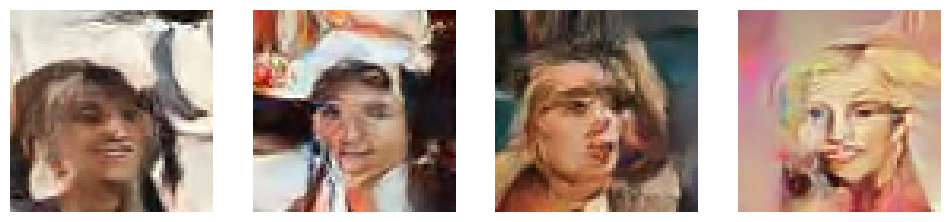

In [ ]:
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer

import matplotlib.pyplot as plt


model = ConvSODEUNet(n_steps=1000)

diffusion = GaussianDiffusion(
    model,
    image_size = 64,
    timesteps = 1000,           # number of steps
    sampling_timesteps = 256    # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
)

trainer = Trainer(
    diffusion,
    #"trainingSet/trainingSet/",
    #"PetImages/Cat",
    #"cifar10/train",
    #"celeba_hq_256",
    "img_align_celeba",
    train_batch_size = 128,
    train_lr =2e-4, #8e-5,
    train_num_steps = 10000, #700000, # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.9999, # 0.995       # exponential moving average decay
    amp = True,                       # turn on mixed precision
    calculate_fid = False             # whether to calculate fid during training
)

trainer.train()

sampled_images = diffusion.sample(batch_size = 4)
sampled_images = sampled_images.to("cpu")

# Plot the images
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axs[i].imshow(sampled_images[i].permute(1, 2, 0))
    axs[i].axis('off')

# Display the plot
plt.show()

# Denoising cU-Net

Solver: rk4


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/torchdiffeq/_impl/misc.py:11: UserWarning: RK4: Unexpected arguments {'max_num_steps': 1000}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


loading from version 1.8.3


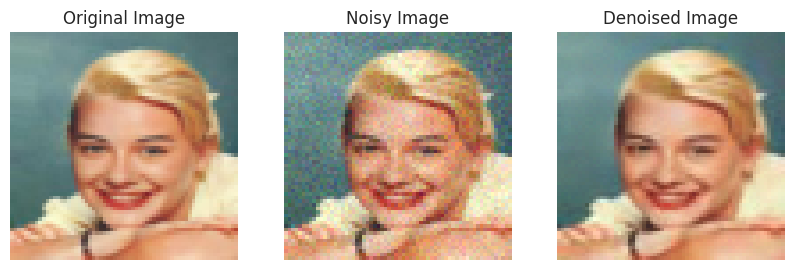

<ipython-input-178-491cc374a095>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"MSE": mse, "PSNR": psnr, "SSIM": ssim,


MSE       PSNR      SSIM  Noise Level  Nº of Timesteps  Elapsed Time
0   0.001776  27.506416  0.910522         0.10             40.0      3.124182
1   0.001748  27.573468  0.910066         0.10             40.0      3.130279
2   0.001784  27.485147  0.907811         0.10             40.0      3.632283
3   0.001706  27.679222  0.911297         0.10             40.0      3.176687
4   0.001752  27.563661  0.910684         0.10             40.0      3.097554
5   0.002941  25.315762  0.873058         0.10            100.0      7.985145
6   0.003371  24.722252  0.862174         0.10            100.0      8.241485
7   0.003219  24.922784  0.861284         0.10            100.0      8.335232
8   0.003071  25.127740  0.867677         0.10            100.0      7.877172
9   0.003482  24.582291  0.855609         0.10            100.0      8.279044
10  0.006892  21.616635  0.775081         0.30            200.0     16.388262
11  0.007698  21.136021  0.765653         0.30            200.0     16.013728
12  0.006722  21.725205  0.788359         0.30            200.0     16.717042
13  0.006572  21.823121  0.771617         0.30            200.0     15.941636
14  0.007000  21.549194  0.780757         0.30            200.0     16.111339
15  0.002062  26.857417  0.892457         0.15             20.0      1.581426
16  0.002129  26.718044  0.885487         0.15             20.0      1.601678
17  0.002204  26.567254  0.886010         0.15             20.0      1.579113
18  0.002096  26.786380  0.889670         0.15             20.0      1.696019
19  0.002038  26.908914  0.892761         0.15             20.0      1.590575
20  0.000832  30.796576  0.950174         0.05             10.0      0.799959
21  0.000888  30.515023  0.947919         0.05             10.0      1.036374
22  0.000855  30.681684  0.947798         0.05             10.0      0.780890
23  0.000847  30.721375  0.949670         0.05             10.0      0.788402
24  0.000836  30.778379  0.948898         0.05             10.0      0.783383
25  0.002692  25.699952  0.835525         0.10              5.0      0.527003
26  0.002763  25.585719  0.831154         0.10              5.0      0.412746
27  0.002675  25.726516  0.838300         0.10              5.0      0.434403
28  0.002848  25.454112  0.826181         0.10              5.0      0.393926
29  0.002720  25.655045  0.834119         0.10              5.0      0.400607
30  0.000862  30.642639  0.937862         0.05              2.0      0.167437
31  0.000847  30.722364  0.939665         0.05              2.0      0.192220
32  0.000819  30.868070  0.940213         0.05              2.0      0.181995
33  0.000862  30.644196  0.938381         0.05              2.0      0.151277
34  0.000412  33.852520  0.969339         0.03              1.0      0.076436
35  0.000400  33.974002  0.970122         0.03              1.0      0.093021
36  0.000403  33.947712  0.969502         0.03              1.0      0.087669
37  0.000395  34.035902  0.970323         0.03              1.0      0.100501
38  0.000395  34.028562  0.970083         0.03              1.0      0.112554
39  0.000504  32.977905  0.965511         0.04              2.0      0.169370
40  0.000496  33.040864  0.965810         0.04              2.0      0.163668
41  0.000520  32.843738  0.964172         0.04              2.0      0.158217
42  0.000521  32.827523  0.964687         0.04              2.0      0.161737
43  0.000528  32.772577  0.964108         0.04              2.0      0.152934
44  0.000789  31.030042  0.941184         0.04              1.0      0.086653
45  0.000762  31.178305  0.941568         0.04              1.0      0.101164
46  0.000771  31.129498  0.941656         0.04              1.0      0.076635
47  0.000796  30.992826  0.940442         0.04              1.0      0.109587
48  0.000769  31.141232  0.942665         0.04              1.0      0.080095
49  0.000463  33.344519  0.971369         0.04              3.0      0.241025
50  0.000468  33.298459  0.9716

In [ ]:
import torch
import pandas as pd
from skimage import metrics
import os
import time
import matplotlib.pyplot as plt
from torchvision import transforms
from denoising_diffusion_pytorch import GaussianDiffusion, Trainer

# Load the model (assuming you have already trained it)
model = ConvSODEUNet(n_steps=1000)

# Initialize the GaussianDiffusion with the trained model
diffusion = GaussianDiffusion(
    model,
    image_size = 64,
    timesteps = 1000,
    sampling_timesteps = 256
)

# Instantiate the trainer and pass the diffusion model
trainer = Trainer(
    diffusion,
    "img_align_celeba",
    train_batch_size=128,
    train_lr=2e-4,
    train_num_steps=10000,
    gradient_accumulate_every=2,
    ema_decay=0.9999,
    amp=True,
    calculate_fid=False
)

# Load the desired model
milestone = 500  # Specify the milestone or identifier of the saved model
trainer.load(milestone)

# Access the loaded model
model = trainer.model
model = model.cpu()

# Ensure the model is in evaluation mode
model.eval()

# Assuming you have a noisy_image tensor with shape [batch_size, channels, height, width]
# Load the image
image_path = "img_align_celeba/135013.jpg" #"test/Image_8.jpg"
image = Image.open(image_path)

# Define the transformations: resize and convert to tensor
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # assuming that your model expects 64x64 images
    transforms.ToTensor(),
])

# Apply transformations
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Add noise to the image
eps = 0.04
noise = torch.randn_like(image_tensor) * eps
# 0.4 -> ~84 timesteps
# 0.2 -> ~55 timesteps

noisy_image = image_tensor + noise

# Ensure the values are between 0 and 1 after adding noise
noisy_image = torch.clamp(noisy_image, 0, 1)

# Generate the noise schedule (you can adjust the number of sampling steps)
num_timesteps = 4

start_time = time.time()

# Perform the denoising task
with torch.no_grad():
    # Condition the model on the noisy image and sample in the reverse process
    # x -> denoised image tensor
    current_image = noisy_image
    for t in reversed(range(num_timesteps)):
        t_tensor = torch.tensor([t], dtype=torch.long)
        model_mean, _, _, _ = diffusion.p_mean_variance(current_image, t_tensor)
        current_image = torch.normal(mean=model_mean, std=torch.ones_like(model_mean) * 0.005)  # You can adjust the noise level here

end_time = time.time()
elapsed_time = end_time - start_time

# Convert tensors to numpy arrays for plotting
original_image_np = image_tensor.squeeze().detach().cpu().numpy()
noisy_image_np = noisy_image.squeeze().detach().cpu().numpy()
current_image_np = current_image.squeeze().detach().cpu().numpy()

# Transpose the dimensions to match the expected format (H, W, C)
original_image_np = np.transpose(original_image_np, (1, 2, 0))
noisy_image_np = np.transpose(noisy_image_np, (1, 2, 0))
current_image_np = np.transpose(current_image_np, (1, 2, 0))

# Clip the pixel values to the valid range [0, 1]
original_image_np = np.clip(original_image_np, 0, 1)
noisy_image_np = np.clip(noisy_image_np, 0, 1)
current_image_np = np.clip(current_image_np, 0, 1)

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Display the original image
axs[0].imshow(original_image_np)
axs[0].axis('off')
axs[0].set_title('Original Image')

# Display the noisy image
axs[1].imshow(noisy_image_np)
axs[1].axis('off')
axs[1].set_title('Noisy Image')

# Display the denoised image
axs[2].imshow(current_image_np)
axs[2].axis('off')
axs[2].set_title('Denoised Image')

# Show the plot
plt.show()

# Calculate the metrics
mse = metrics.mean_squared_error(original_image_np, current_image_np)
psnr = metrics.peak_signal_noise_ratio(original_image_np, current_image_np, data_range=1)
ssim = metrics.structural_similarity(original_image_np, current_image_np, channel_axis=2)

# Tracking the results in a DataFrame
results_file = "denoising_results_cunet.csv"

# Check if the results file exists
if os.path.exists(results_file):
    # If it exists, read the existing data
    results_df = pd.read_csv(results_file)
else:
    # If it does not exist, create an empty DataFrame with the appropriate columns
    results_df = pd.DataFrame(columns=["MSE", "PSNR", "SSIM", "Noise Level",
                                       "Nº of Timesteps", "Elapsed Time"])

# Append the new data
results_df = results_df.append({"MSE": mse, "PSNR": psnr, "SSIM": ssim,
                                "Noise Level": eps,
                                "Nº of Timesteps": num_timesteps,
                                "Elapsed Time": elapsed_time},
                               ignore_index=True)

# Save the updated DataFrame back to the CSV file
results_df.to_csv(results_file, index=False)

# Optionally, you can print the DataFrame to see the updated data
results_df

## Average results table cU-Net

In [ ]:
average_df = results_df.groupby(['Noise Level', 'Nº of Timesteps'])[['MSE', 'PSNR', 'SSIM', 'Elapsed Time']].mean().reset_index()
average_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Noise Level  Nº of Timesteps       MSE       PSNR      SSIM  Elapsed Time
0          0.03              1.0  0.000401  33.967739  0.969874      0.094036
1          0.04              1.0  0.000777  31.094381  0.941503      0.090827
2          0.04              2.0  0.000514  32.892522  0.964857      0.161185
3          0.04              3.0  0.000469  33.288070  0.971314      0.248209
4          0.04              4.0  0.000551  32.589856  0.966659      0.321031
5          0.05              2.0  0.000850  30.704293  0.938901      0.168841
6          0.05             10.0  0.000852  30.698608  0.948892      0.837802
7          0.10              5.0  0.002740  25.624269  0.833056      0.433737
8          0.10             40.0  0.001753  27.561583  0.910076      3.232197
9          0.10            100.0  0.003217  24.934166  0.863960      8.143615
10         0.15             20.0  0.002106  26.767602  0.889277      1.609762
11         0.30            200.0  0.006977  21.570035  0.776293     16.234401

## Quality metrics evolution cU-Net

Solver: rk4


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


loading from version 1.8.3


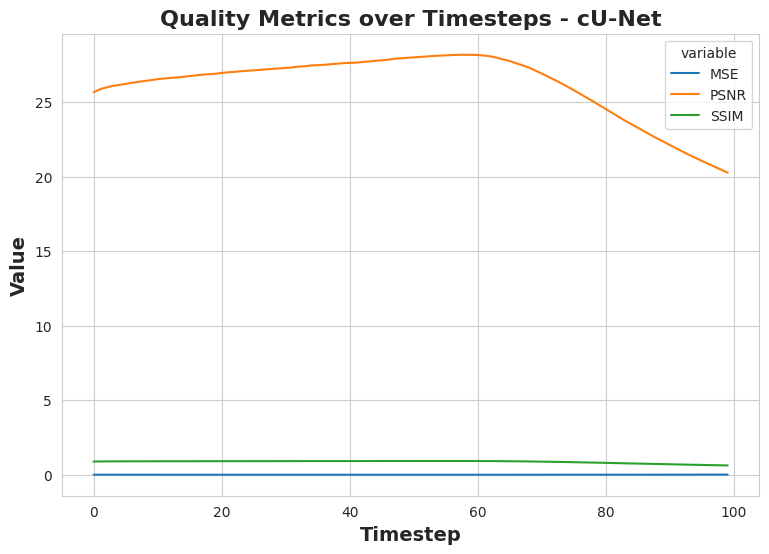

Best MSE Value  Best MSE Step  Best PSNR Value  Best PSNR Step  \
0        0.001517           58.0         28.19142            58.0   

   Best SSIM Value  Best SSIM Step  Noise Level  
0         0.924474            53.0          0.1

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from skimage import metrics
import torch
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from denoising_diffusion_pytorch import GaussianDiffusion, Trainer
import warnings


# Suppress FutureWarning and UserWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Load the model (assuming you have already trained it)
model = ConvSODEUNet(n_steps=1000)

# Initialize the GaussianDiffusion with the trained model
diffusion = GaussianDiffusion(
    model,
    image_size = 64,
    timesteps = 1000,
    sampling_timesteps = 256
)

# Instantiate the trainer and pass the diffusion model
trainer = Trainer(
    diffusion,
    "img_align_celeba",
    train_batch_size=128,
    train_lr=2e-4,
    train_num_steps=10000,
    gradient_accumulate_every=2,
    ema_decay=0.9999,
    amp=True,
    calculate_fid=False
)

# Load the desired model
milestone = 500  # Specify the milestone or identifier of the saved model
trainer.load(milestone)
model = trainer.model
model = model.cpu()
model.eval()

# Load the image
image_path = "img_align_celeba/135013.jpg"
image = Image.open(image_path)
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0)

# Add noise
eps = 0.1
noise = torch.randn_like(image_tensor) * eps
noisy_image = image_tensor + noise
noisy_image = torch.clamp(noisy_image, 0, 1)

# Initialize metrics dataframe
metrics_df = pd.DataFrame(columns=["Step", "MSE", "PSNR", "SSIM"])

# Define timesteps
total_timesteps = 100

# Denoising
with torch.no_grad():
    current_image = noisy_image
    for t in reversed(range(total_timesteps)):
        t_tensor = torch.tensor([t], dtype=torch.long)
        model_mean, _, _, _ = diffusion.p_mean_variance(current_image, t_tensor)
        current_image = torch.normal(mean=model_mean, std=torch.ones_like(model_mean) * 0.005)

        # Convert to numpy and transpose for metrics computation
        current_image_np = np.transpose(current_image.squeeze().cpu().numpy(), (1, 2, 0))
        original_image_np = np.transpose(image_tensor.squeeze().cpu().numpy(), (1, 2, 0))

        # Compute metrics
        mse = metrics.mean_squared_error(original_image_np, current_image_np)
        psnr = metrics.peak_signal_noise_ratio(original_image_np, current_image_np, data_range=1)
        ssim = metrics.structural_similarity(original_image_np, current_image_np, channel_axis=2)

        # Append to dataframe
        metrics_df = metrics_df.append({"Step": t, "MSE": mse, "PSNR": psnr, "SSIM": ssim}, ignore_index=True)

# Get steps where metrics are maximized (or minimized for MSE)
best_mse_step = metrics_df.loc[metrics_df['MSE'].idxmin()]['Step']
best_psnr_step = metrics_df.loc[metrics_df['PSNR'].idxmax()]['Step']
best_ssim_step = metrics_df.loc[metrics_df['SSIM'].idxmax()]['Step']

# Create dataframe to store best values and corresponding steps
best_df = pd.DataFrame({
    "Best MSE Value": [metrics_df['MSE'].min()],
    "Best MSE Step": [best_mse_step],
    "Best PSNR Value": [metrics_df['PSNR'].max()],
    "Best PSNR Step": [best_psnr_step],
    "Best SSIM Value": [metrics_df['SSIM'].max()],
    "Best SSIM Step": [best_ssim_step],
    "Noise Level": eps,
})

# Reset to default warning behavior
warnings.resetwarnings()

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(9, 6))

# Plot the metrics
sns.lineplot(x="Step", y="value", hue="variable", data=pd.melt(metrics_df, ['Step']), ax=ax)

# Set labels and title
ax.set_xlabel('Timestep', fontsize=14, fontweight="bold")
ax.set_ylabel('Value', fontsize=14, fontweight="bold")
ax.set_title('Quality Metrics over Timesteps - cU-Net', fontsize=16, fontweight="bold")

# Show the plot
plt.show()

# File path
file_path = 'metrics_data_cunet.csv'

# Check if file exists
if os.path.isfile(file_path):
    # If it exists, load it and append new data
    existing_df = pd.read_csv(file_path, index_col=0)
    updated_df = pd.concat([existing_df, best_df], ignore_index=True)
else:
    # If it does not exist, use the current data
    updated_df = best_df

# Save the updated dataframe to csv
updated_df.to_csv(file_path)

best_df

In [ ]:
metrics_ev_cunet = pd.read_csv("metrics_data_cunet.csv", index_col=0)
metrics_ev_cunet

Best MSE Value  Best MSE Step  Best PSNR Value  Best PSNR Step  \
0        0.001499           59.0        28.241621            59.0   
1        0.000734           79.0        31.342388            79.0   
2        0.002917           26.0        25.350500            26.0   
3        0.002067           42.0        26.845702            42.0   
4        0.000297           94.0        35.274878            94.0   

   Best SSIM Value  Best SSIM Step  Noise Level  
0         0.923820            56.0         0.10  
1         0.956224            77.0         0.05  
2         0.863753            26.0         0.20  
3         0.901529            41.0         0.15  
4         0.978226            93.0         0.02

## Delete last row cU-Net table

In [ ]:
import pandas as pd

# Read the CSV file
results_df = pd.read_csv('denoising_results_cunet.csv')

# Remove the last row
results_df = results_df[:-1]

# Save the modified DataFrame back to the same file
results_df.to_csv('denoising_results_cunet.csv', index=False)

## Denoising U-Net

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


loading from version 1.8.3


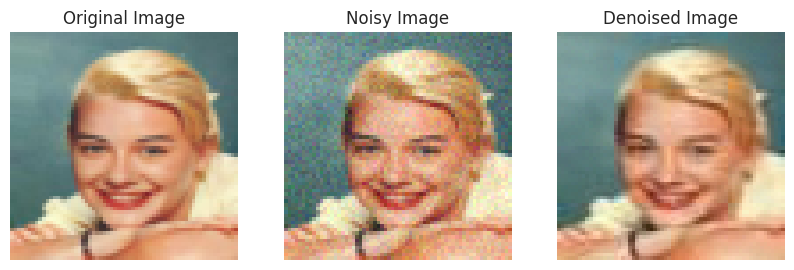

<ipython-input-198-028b7cd68234>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_unet = results_df.append({"MSE": mse, "PSNR": psnr, "SSIM": ssim,


MSE       PSNR      SSIM  Noise Level  Nº of Timesteps  Elapsed Time
0   0.001776  27.506416  0.910522         0.10             40.0      3.124182
1   0.001748  27.573468  0.910066         0.10             40.0      3.130279
2   0.001784  27.485147  0.907811         0.10             40.0      3.632283
3   0.001706  27.679222  0.911297         0.10             40.0      3.176687
4   0.001752  27.563661  0.910684         0.10             40.0      3.097554
..       ...        ...       ...          ...              ...           ...
56  0.000546  32.631700  0.966398         0.04              4.0      0.321999
57  0.000561  32.507688  0.966711         0.04              4.0      0.307980
58  0.000537  32.697807  0.967808         0.04              4.0      0.347456
59  0.000552  32.578124  0.966447         0.04              4.0      0.308562
60  0.001071  29.703018  0.942850         0.04              4.0      0.361478

[61 rows x 6 columns]

In [ ]:
import torch
import pandas as pd
from skimage import metrics
from PIL import Image
import os
import time
import matplotlib.pyplot as plt
from torchvision import transforms
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer

# Load the model (assuming you have already trained it)
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = False
)

# Initialize the GaussianDiffusion with the trained model
diffusion = GaussianDiffusion(
    model,
    image_size = 64,
    timesteps = 1000,
    sampling_timesteps = 256
)

# Instantiate the trainer and pass the diffusion model
trainer = Trainer(
    diffusion,
    "img_align_celeba",
    train_batch_size=128,
    train_lr=2e-4,
    train_num_steps=10000,
    gradient_accumulate_every=2,
    ema_decay=0.9999,
    amp=True,
    calculate_fid=False
)

# Load the desired model
milestone = 100  # Specify the milestone or identifier of the saved model
trainer.load(milestone)

# Access the loaded model
model = trainer.model
model = model.cpu()

# Ensure the model is in evaluation mode
model.eval()

# Assuming you have a noisy_image tensor with shape [batch_size, channels, height, width]
# Load the image
image_path = "img_align_celeba/135013.jpg" #"test/Image_8.jpg"
image = Image.open(image_path)

# Define the transformations: resize and convert to tensor
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # assuming that your model expects 64x64 images
    transforms.ToTensor(),
])

# Apply transformations
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Add noise to the image
eps = 0.04
noise = torch.randn_like(image_tensor) * eps
# 0.4 -> ~84 timesteps
# 0.2 -> ~55 timesteps

noisy_image = image_tensor + noise

# Ensure the values are between 0 and 1 after adding noise
noisy_image = torch.clamp(noisy_image, 0, 1)

# Generate the noise schedule (you can adjust the number of sampling steps)
num_timesteps = 4

start_time = time.time()

# Perform the denoising task
with torch.no_grad():
    # Condition the model on the noisy image and sample in the reverse process
    # x -> denoised image tensor
    current_image = noisy_image
    for t in reversed(range(num_timesteps)):
        t_tensor = torch.tensor([t], dtype=torch.long)
        model_mean, _, _, _ = diffusion.p_mean_variance(current_image, t_tensor)
        current_image = torch.normal(mean=model_mean, std=torch.ones_like(model_mean) * 0.005)  # You can adjust the noise level here

end_time = time.time()
elapsed_time = end_time - start_time

# Convert tensors to numpy arrays for plotting
original_image_np = image_tensor.squeeze().detach().cpu().numpy()
noisy_image_np = noisy_image.squeeze().detach().cpu().numpy()
current_image_np = current_image.squeeze().detach().cpu().numpy()

# Transpose the dimensions to match the expected format (H, W, C)
original_image_np = np.transpose(original_image_np, (1, 2, 0))
noisy_image_np = np.transpose(noisy_image_np, (1, 2, 0))
current_image_np = np.transpose(current_image_np, (1, 2, 0))

# Clip the pixel values to the valid range [0, 1]
original_image_np = np.clip(original_image_np, 0, 1)
noisy_image_np = np.clip(noisy_image_np, 0, 1)
current_image_np = np.clip(current_image_np, 0, 1)

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Display the original image
axs[0].imshow(original_image_np)
axs[0].axis('off')
axs[0].set_title('Original Image')

# Display the noisy image
axs[1].imshow(noisy_image_np)
axs[1].axis('off')
axs[1].set_title('Noisy Image')

# Display the denoised image
axs[2].imshow(current_image_np)
axs[2].axis('off')
axs[2].set_title('Denoised Image')

# Show the plot
plt.show()

# Calculate the metrics
mse = metrics.mean_squared_error(original_image_np, current_image_np)
psnr = metrics.peak_signal_noise_ratio(original_image_np, current_image_np, data_range=1)
ssim = metrics.structural_similarity(original_image_np, current_image_np, channel_axis=2)

# Tracking the results in a DataFrame
results_file = "denoising_results_unet.csv"

# Check if the results file exists
if os.path.exists(results_file):
    # If it exists, read the existing data
    results_df_unet = pd.read_csv(results_file)
else:
    # If it does not exist, create an empty DataFrame with the appropriate columns
    results_df_unet = pd.DataFrame(columns=["MSE", "PSNR", "SSIM", "Noise Level",
                                       "Nº of Timesteps", "Elapsed Time"])

# Append the new data
results_df_unet = results_df.append({"MSE": mse, "PSNR": psnr, "SSIM": ssim,
                                "Noise Level": eps,
                                "Nº of Timesteps": num_timesteps,
                                "Elapsed Time": elapsed_time},
                               ignore_index=True)

# Save the updated DataFrame back to the CSV file
results_df_unet.to_csv(results_file, index=False)

# Optionally, you can print the DataFrame to see the updated data
results_df_unet

## Average table U-Net

In [ ]:
average_df_unet = results_df_unet.groupby(['Noise Level', 'Nº of Timesteps'])[['MSE', 'PSNR', 'SSIM', 'Elapsed Time']].mean().reset_index()
average_df_unet

Noise Level  Nº of Timesteps       MSE       PSNR      SSIM  Elapsed Time
0          0.03              1.0  0.000513  32.898330  0.964891      0.093441
1          0.04              1.0  0.000775  31.104561  0.944339      0.091336
2          0.04              2.0  0.000765  31.163566  0.953428      0.189421
3          0.04              3.0  0.000921  30.355550  0.949260      0.293348
4          0.04              4.0  0.001066  29.723231  0.942721      0.372157
5          0.05              2.0  0.000951  30.216578  0.938823      0.201245
6          0.05             10.0  0.001271  28.960259  0.933485      1.058557
7          0.10              5.0  0.002569  25.904897  0.846580      0.527277
8          0.10             40.0  0.001779  27.499035  0.909663      3.864100
9          0.10            100.0  0.002461  26.089667  0.878427      9.601570
10         0.15             20.0  0.004462  23.506716  0.768918      2.077618
11         0.30            200.0  0.005052  22.972388  0.791516     19.536800

## Delete last row of denoising_results_unet.csv

In [ ]:
import pandas as pd

# Read the CSV file
results_df_unet = pd.read_csv('denoising_results_unet.csv')

# Remove the last row
results_df_unet = results_df_unet[:-1]

# Save the modified DataFrame back to the same file
results_df_unet.to_csv('denoising_results_unet.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Quality metrics over time steps U-Net

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


loading from version 1.8.3


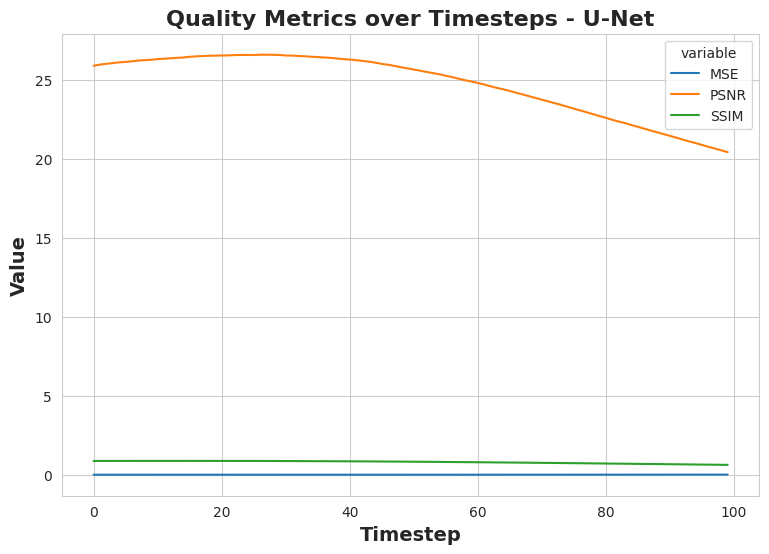

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

Best MSE Value  Best MSE Step  Best PSNR Value  Best PSNR Step  \
0        0.002196           27.0        26.583616            27.0   

   Best SSIM Value  Best SSIM Step  Noise Level  
0         0.877913            15.0          0.1

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from skimage import metrics
import torch
import time
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from denoising_diffusion_pytorch import GaussianDiffusion, Trainer
import warnings


# Suppress FutureWarning and UserWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Load the model (assuming you have already trained it)
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = False
)

# Initialize the GaussianDiffusion with the trained model
diffusion = GaussianDiffusion(
    model,
    image_size = 64,
    timesteps = 1000,
    sampling_timesteps = 256
)

# Instantiate the trainer and pass the diffusion model
trainer = Trainer(
    diffusion,
    "img_align_celeba",
    train_batch_size=128,
    train_lr=2e-4,
    train_num_steps=10000,
    gradient_accumulate_every=2,
    ema_decay=0.9999,
    amp=True,
    calculate_fid=False
)

# Load the desired model
milestone = 499  # Specify the milestone or identifier of the saved model
trainer.load(milestone)

# Access the loaded model
model = trainer.model
model = model.cpu()
model.eval()

# Load the image
image_path = "img_align_celeba/135013.jpg"
image = Image.open(image_path)
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0)

# Add noise
eps = 0.1
noise = torch.randn_like(image_tensor) * eps
noisy_image = image_tensor + noise
noisy_image = torch.clamp(noisy_image, 0, 1)

# Initialize metrics dataframe
metrics_df = pd.DataFrame(columns=["Step", "MSE", "PSNR", "SSIM"])

# Define timesteps
total_timesteps = 100

# Denoising
with torch.no_grad():
    current_image = noisy_image
    for t in reversed(range(total_timesteps)):
        t_tensor = torch.tensor([t], dtype=torch.long)
        model_mean, _, _, _ = diffusion.p_mean_variance(current_image, t_tensor)
        current_image = torch.normal(mean=model_mean, std=torch.ones_like(model_mean) * 0.005)

        # Convert to numpy and transpose for metrics computation
        current_image_np = np.transpose(current_image.squeeze().cpu().numpy(), (1, 2, 0))
        original_image_np = np.transpose(image_tensor.squeeze().cpu().numpy(), (1, 2, 0))

        # Compute metrics
        mse = metrics.mean_squared_error(original_image_np, current_image_np)
        psnr = metrics.peak_signal_noise_ratio(original_image_np, current_image_np, data_range=1)
        ssim = metrics.structural_similarity(original_image_np, current_image_np, channel_axis=2)

        # Append to dataframe
        metrics_df = metrics_df.append({"Step": t, "MSE": mse, "PSNR": psnr, "SSIM": ssim}, ignore_index=True)

# Get steps where metrics are maximized (or minimized for MSE)
best_mse_step = metrics_df.loc[metrics_df['MSE'].idxmin()]['Step']
best_psnr_step = metrics_df.loc[metrics_df['PSNR'].idxmax()]['Step']
best_ssim_step = metrics_df.loc[metrics_df['SSIM'].idxmax()]['Step']

# Create dataframe to store best values and corresponding steps
best_df = pd.DataFrame({
    "Best MSE Value": [metrics_df['MSE'].min()],
    "Best MSE Step": [best_mse_step],
    "Best PSNR Value": [metrics_df['PSNR'].max()],
    "Best PSNR Step": [best_psnr_step],
    "Best SSIM Value": [metrics_df['SSIM'].max()],
    "Best SSIM Step": [best_ssim_step],
    "Noise Level": eps,
})

# Reset to default warning behavior
warnings.resetwarnings()

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(9, 6))

# Plot the metrics
sns.lineplot(x="Step", y="value", hue="variable", data=pd.melt(metrics_df, ['Step']), ax=ax)

# Add vertical lines at the steps with best PSNR for each model
ax.axvline(x=best_psnr_step, color='orange', linestyle='--')

# Set labels and title
ax.set_xlabel('Timestep', fontsize=14, fontweight="bold")
ax.set_ylabel('Value', fontsize=14, fontweight="bold")
ax.set_title('Quality Metrics over Timesteps - U-Net', fontsize=16, fontweight="bold")

# Show the plot
plt.show()

# File path
file_path = 'metrics_data_unet.csv'

# Check if file exists
if os.path.isfile(file_path):
    # If it exists, load it and append new data
    existing_df = pd.read_csv(file_path, index_col=0)
    updated_df = pd.concat([existing_df, best_df], ignore_index=True)
else:
    # If it does not exist, use the current data
    updated_df = best_df

# Save the updated dataframe to csv
updated_df.to_csv(file_path)

best_df

In [ ]:
metrics_ev_unet = pd.read_csv("metrics_data_unet.csv", index_col=0)
metrics_ev_unet

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best MSE Value  Best MSE Step  Best PSNR Value  Best PSNR Step  \
0        0.002089           25.0        26.800651            25.0   
1        0.001569           56.0        28.043279            56.0   
2        0.002648            6.0        25.770018             6.0   
3        0.002440           13.0        26.126379            13.0   
4        0.000412           99.0        33.855506            99.0   

   Best SSIM Value  Best SSIM Step  Noise Level  
0         0.882627             8.0         0.10  
1         0.895309            42.0         0.05  
2         0.869738             4.0         0.20  
3         0.870890             8.0         0.15  
4         0.965245            99.0         0.02

## U-Net vs cU-Net

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from skimage import metrics
import torch
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
import warnings

In [ ]:
# Load cU-Net
model = ConvSODEUNet(n_steps=1000)

# Initialize the GaussianDiffusion with the trained model
diffusion = GaussianDiffusion(
    model,
    image_size = 64,
    timesteps = 1000,
    sampling_timesteps = 256
)

# Instantiate the trainer and pass the diffusion model
trainer = Trainer(
    diffusion,
    "img_align_celeba",
    train_batch_size=128,
    train_lr=2e-4,
    train_num_steps=10000,
    gradient_accumulate_every=2,
    ema_decay=0.9999,
    amp=True,
    calculate_fid=False
)

# Load the desired model
milestone = 125 # Specify the milestone or identifier of the saved model
trainer.load(milestone)
model = trainer.model
model = model.cpu()
model.eval()

In [ ]:
class ODEBlock(nn.Module):
    def __init__(self, odefunc, tol=1e-3, adjoint=False):
        """
        Code adapted from https://github.com/EmilienDupont/augmented-neural-odes
        Utility class that wraps odeint and odeint_adjoint.
        Args:
            odefunc (nn.Module): the module to be evaluated
            tol (float): tolerance for the ODE solver
            adjoint (bool): whether to use the adjoint method for gradient calculation
        """
        super(ODEBlock, self).__init__()
        self.adjoint = adjoint
        self.odefunc = odefunc
        self.tol = tol

    def forward(self, x, eval_times=None, method="rk4"):
        # Forward pass corresponds to solving ODE, so reset number of function
        # evaluations counter
        self.odefunc.nfe = 0

        if eval_times is None:
            integration_time = torch.tensor([0, 1]).float().type_as(x)
        else:
            integration_time = eval_times.type_as(x)

        if self.adjoint:
            out = odeint_adjoint(
                self.odefunc,
                x,
                integration_time,
                rtol=self.tol,
                atol=self.tol,
                method=method,
                options={"max_num_steps": MAX_NUM_STEPS},
            )
        else:
            out = odeint(
                self.odefunc,
                x,
                integration_time,
                rtol=self.tol,
                atol=self.tol,
                method=method,
                options={"max_num_steps": MAX_NUM_STEPS},
            )

        if eval_times is None:
            return out[1]  # out[1][:int(len(x)/2)]  Return only final time
        else:
            return out

    def trajectory(self, x, timesteps):
        integration_time = torch.linspace(0.0, 1.0, timesteps)
        return self.forward(x, eval_times=integration_time)


class ConvSODEFunc(nn.Module):
    def __init__(self, nf, time_dependent=False, non_linearity="relu"):
        """
        Block for ConvSODEUNet. Designed to be used as the function f that defines
        the derivative in an ODE of the form dz/dt = f(t, z). This function represents
        how the hidden state z changes with respect to the continuous time variable t.

        ConvSODE defines the actual transformation of the datam while the ODE
        block is responsible for solving the ODE defined by that transformation.

        Args:
            nf (int): number of filters for the conv layers
            time_dependent (bool): whether to concat the time as a feature map before the convs
            non_linearity (str): which non_linearity to use (for options see get_nonlinearity)
        """
        super(ConvSODEFunc, self).__init__()
        self.time_dependent = time_dependent
        self.nfe = 0  # Number of function evaluations

        if time_dependent:
            self.norm1 = nn.InstanceNorm2d(nf)
            self.conv1 = Conv2dTime(nf, nf, kernel_size=3, stride=1, padding=1)
            self.norm2 = nn.InstanceNorm2d(nf)
            self.conv2 = Conv2dTime(nf, nf, kernel_size=3, stride=1, padding=1)
        else:
            self.norm1 = nn.InstanceNorm2d(nf)
            self.conv1 = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1)
            self.norm2 = nn.InstanceNorm2d(nf)
            # changed to kernel_size 1 with padding 0 instead of 1
            self.conv2 = nn.Conv2d(nf, nf, kernel_size=1, stride=1, padding=0)

        self.non_linearity = get_nonlinearity(non_linearity)

    def forward(self, t, x):
        cutoff = int(x.shape[1] / 2)  # int(len(x)/2)
        # Typical in neural ODEs as they usually operate in anaugmented state space
        z = x[:, :cutoff]
        v = x[:, cutoff:]
        into = torch.cat((z, v), dim=1)
        self.nfe += 1
        if self.time_dependent:
            out = self.norm1(into)
            out = self.conv1(t, into)
            out = self.non_linearity(out)
            out = self.norm2(out)
            out = self.conv2(t, out)
            out = self.non_linearity(out)
        else:
            out = self.norm1(into)
            out = self.conv1(out)
            out = self.non_linearity(out)
            out = self.norm2(out)
            out = self.conv2(out)
            out = self.non_linearity(out)
        return out


# Second-order ODE UNet
class ConvSODEUNet2(nn.Module):
    def __init__(
        self,
        n_steps=1000,
        time_emb_dim=256, # num_filters*16
        channels=3, # change to 3
        num_filters=16,
        out_dim=3, # change to 3
        time_dependent=False,
        non_linearity="softplus",
        tol=1e-3,
        adjoint=False,
        method="rk4"
    ):
        """
        ConvSODEUNet (Second order ODE UNet)
        Args:
            num_filters (int): number of filters for first conv layer
            output_dim (int): how many feature maps the network outputs
            time_dependent (bool): whether to concat the time as a feature map before the convs
            non_linearity (str): which non_linearity to use (for options see get_nonlinearity)
            tol (float): tolerance to be used for ODE solver
            adjoint (bool): whether to use the adjoint method to calculate the gradients
        """
        super(ConvSODEUNet2, self).__init__()
        nf = num_filters
        self.method = method
        print(f"Solver: {method}")

        #################################################################
        self.channels = channels
        self.out_dim = out_dim
        self.random_or_learned_sinusoidal_cond = None
        self.self_condition = False
        #################################################################

        #################################################################
        self.attention_encoder4 = Attention(dim=nf*16)

        self.attention_decoder1 = Attention(dim=nf*16)
        #################################################################

        #################################################################
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # Time embeddings
        self.te1 = self._make_te(time_emb_dim, nf*2)
        self.te2 = self._make_te(time_emb_dim, nf * 4)
        self.te3 = self._make_te(time_emb_dim, nf * 8)
        self.te4 = self._make_te(time_emb_dim, nf * 16)
        self.te_emb = self._make_te(time_emb_dim, nf * 32)
        self.te_up1 = self._make_te(time_emb_dim, nf * 16)
        self.te_up2 = self._make_te(time_emb_dim, nf * 8)
        self.te_up3 = self._make_te(time_emb_dim, nf * 4)
        self.te_up4 = self._make_te(time_emb_dim, nf * 2)
        #################################################################
        self.initial_velocity = InitialVelocity(nf, non_linearity)

        ode_down1 = ConvSODEFunc(nf * 2, time_dependent, non_linearity) # 32
        self.odeblock_down1 = ODEBlock(ode_down1, tol=tol, adjoint=adjoint)
        self.conv_down1_2 = nn.Conv2d(nf * 2, nf * 4, 1, 1)

        ode_down2 = ConvSODEFunc(nf * 4, time_dependent, non_linearity) # 64
        self.odeblock_down2 = ODEBlock(ode_down2, tol=tol, adjoint=adjoint)
        self.conv_down2_3 = nn.Conv2d(nf * 4, nf * 8, 1, 1)

        ode_down3 = ConvSODEFunc(nf * 8, time_dependent, non_linearity) # 128
        self.odeblock_down3 = ODEBlock(ode_down3, tol=tol, adjoint=adjoint)
        self.conv_down3_4 = nn.Conv2d(nf * 8, nf * 16, 1, 1)

        ode_down4 = ConvSODEFunc(nf * 16, time_dependent, non_linearity) # 256
        self.odeblock_down4 = ODEBlock(ode_down4, tol=tol, adjoint=adjoint)
        self.conv_down4_embed = nn.Conv2d(nf * 16, nf * 32, 1, 1)

        ode_embed = ConvSODEFunc(nf * 32, time_dependent, non_linearity) # 512
        self.odeblock_embedding = ODEBlock(ode_embed, tol=tol, adjoint=adjoint)
        self.conv_up_embed_1 = nn.Conv2d(nf * 32 + nf * 16, nf * 16, 1, 1)

        ode_up1 = ConvSODEFunc(nf * 16, time_dependent, non_linearity) # 256
        self.odeblock_up1 = ODEBlock(ode_up1, tol=tol, adjoint=adjoint)
        self.conv_up1_2 = nn.Conv2d(nf * 16 + nf * 8, nf * 8, 1, 1)

        ode_up2 = ConvSODEFunc(nf * 8, time_dependent, non_linearity) # 128
        self.odeblock_up2 = ODEBlock(ode_up2, tol=tol, adjoint=adjoint)
        self.conv_up2_3 = nn.Conv2d(nf * 8 + nf * 4, nf * 4, 1, 1)

        ode_up3 = ConvSODEFunc(nf * 4, time_dependent, non_linearity) # 64
        self.odeblock_up3 = ODEBlock(ode_up3, tol=tol, adjoint=adjoint)
        self.conv_up3_4 = nn.Conv2d(nf * 4 + nf * 2, nf * 2, 1, 1)

        ode_up4 = ConvSODEFunc(nf * 2, time_dependent, non_linearity) # 32
        self.odeblock_up4 = ODEBlock(ode_up4, tol=tol, adjoint=adjoint)

        self.classifier = nn.Conv2d(nf * 2, out_dim, 1)

        self.non_linearity = get_nonlinearity(non_linearity)

    def forward(self, x, t, dummy=None):
      t = self.time_embed(t)
      n = len(x)
      x = self.initial_velocity(x) + self.te1(t).reshape(n, -1, 1, 1)

      features1 = self.odeblock_down1(x, method=self.method)
      x = self.non_linearity(self.conv_down1_2(features1) + self.te2(t).reshape(n, -1, 1, 1))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      features2 = self.odeblock_down2(x, method=self.method)
      x = self.non_linearity(self.conv_down2_3(features2) + self.te3(t).reshape(n, -1, 1, 1))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      features3 = self.odeblock_down3(x, method=self.method)
      x = self.non_linearity(self.conv_down3_4(features3) + self.te4(t).reshape(n, -1, 1, 1))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      features4 = self.odeblock_down4(x, method=self.method)
      features4 = self.attention_encoder4(features4) # Attention in encoder
      x = self.non_linearity(self.conv_down4_embed(features4) + self.te_emb(t).reshape(n, -1, 1, 1))
      x = nn.functional.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)

      x = self.odeblock_embedding(x, method=self.method)

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features4), dim=1)
      x = self.non_linearity(self.conv_up_embed_1(x) + self.te_up1(t).reshape(n, -1, 1, 1))
      x = self.odeblock_up1(x,  method=self.method)
      x = self.attention_decoder1(x)  # Attention in decoder

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features3), dim=1)
      x = self.non_linearity(self.conv_up1_2(x) + self.te_up2(t).reshape(n, -1, 1, 1))
      x = self.odeblock_up2(x,  method=self.method)

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features2), dim=1)
      x = self.non_linearity(self.conv_up2_3(x) + self.te_up3(t).reshape(n, -1, 1, 1))
      x = self.odeblock_up3(x,  method=self.method)

      x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
      x = torch.cat((x, features1), dim=1)
      x = self.non_linearity(self.conv_up3_4(x) + self.te_up4(t).reshape(n, -1, 1, 1))
      x = self.odeblock_up4(x,  method=self.method)

      pred = self.classifier(x)
      return pred


    def _make_te(self, dim_in, dim_out):
        """
        Utility function that creates a one-layer MLP which will be used to map a positional embedding.

        Args:
            dim_in (int): The input dimensionality.
            dim_out (int): The output dimensionality.

        Returns:
            nn.Sequential: The MLP model.

        """
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [ ]:
# Load U-Net
model_2 = ConvSODEUNet2(n_steps=1000)

diffusion_2 = GaussianDiffusion(
    model_2,
    image_size = 64,
    timesteps = 1000,
    sampling_timesteps = 256
)

trainer_2 = Trainer(
    diffusion_2,
    "img_align_celeba",
    train_batch_size=128,
    train_lr=2e-4,
    train_num_steps=10000,
    gradient_accumulate_every=2,
    ema_decay=0.9999,
    amp=True,
    calculate_fid=False
)

milestone_2 = 124
trainer_2.load(milestone_2)
model_2 = trainer_2.model
model_2 = model_2.cpu()
model_2.eval()

In [ ]:
# Load U-Net
model_2 = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = False
)

diffusion_2 = GaussianDiffusion(
    model_2,
    image_size = 64,
    timesteps = 1000,
    sampling_timesteps = 256
)

trainer_2 = Trainer(
    diffusion_2,
    "img_align_celeba",
    train_batch_size=128,
    train_lr=2e-4,
    train_num_steps=10000,
    gradient_accumulate_every=2,
    ema_decay=0.9999,
    amp=True,
    calculate_fid=False
)

milestone_2 = 499
trainer_2.load(milestone_2)
model_2 = trainer_2.model
model_2 = model_2.cpu()
model_2.eval()

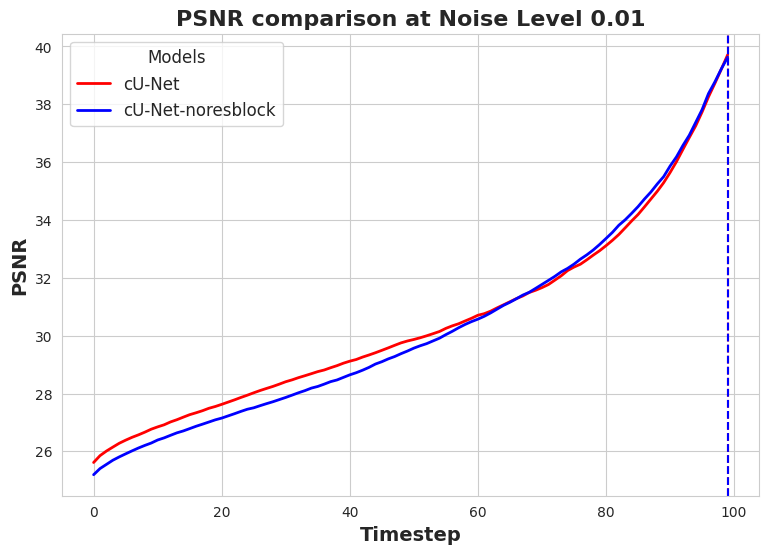

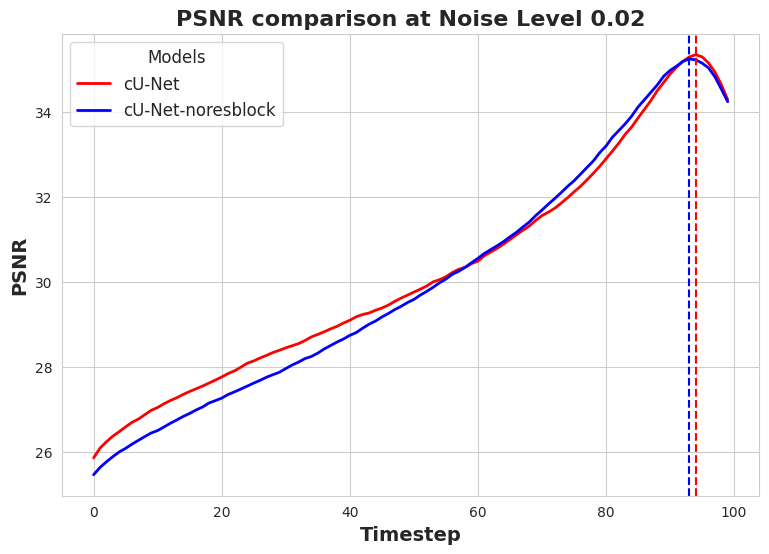

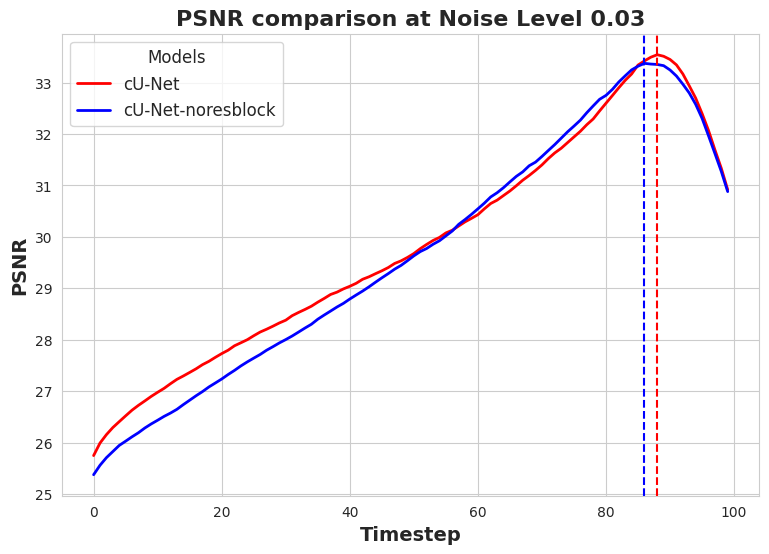

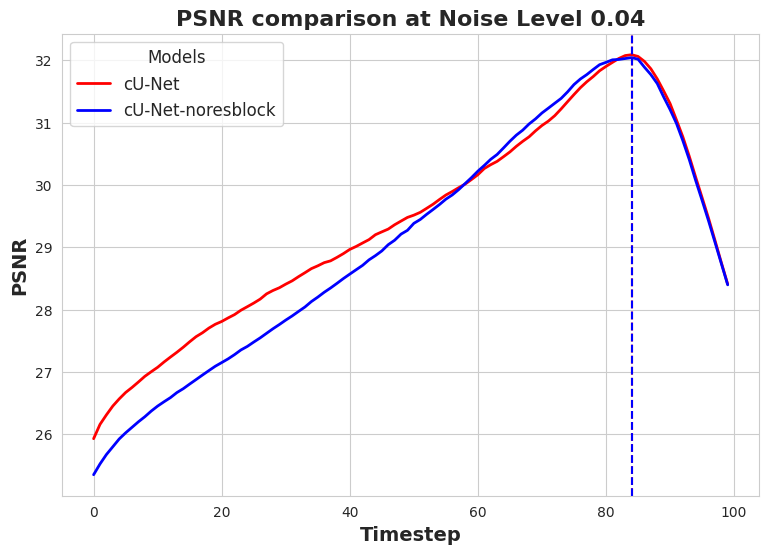

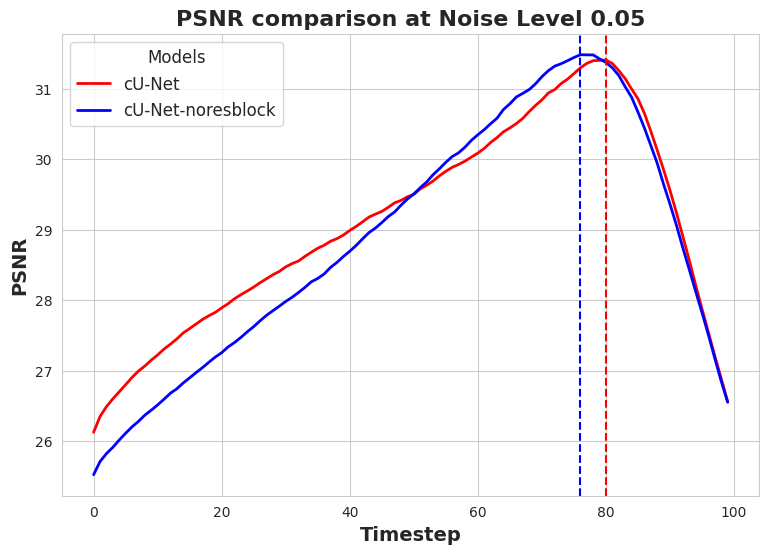

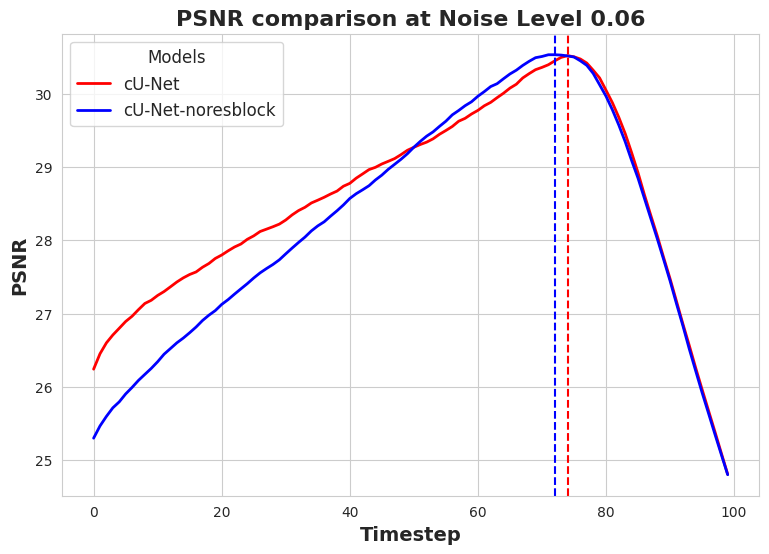

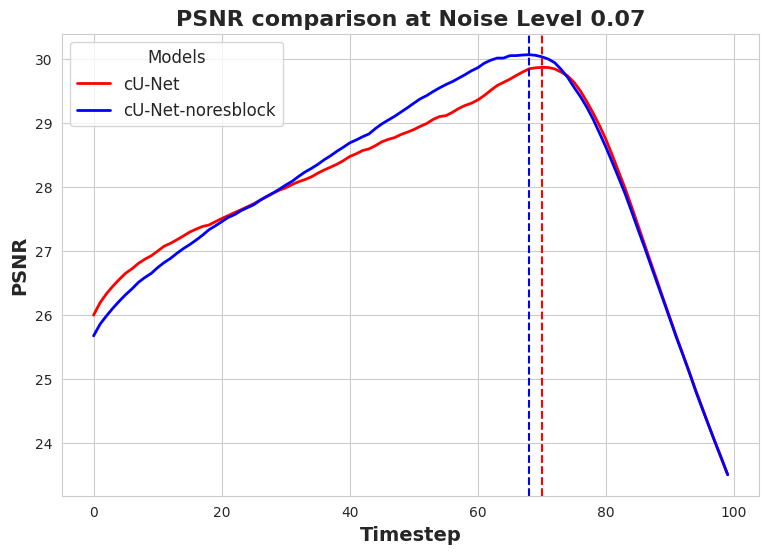

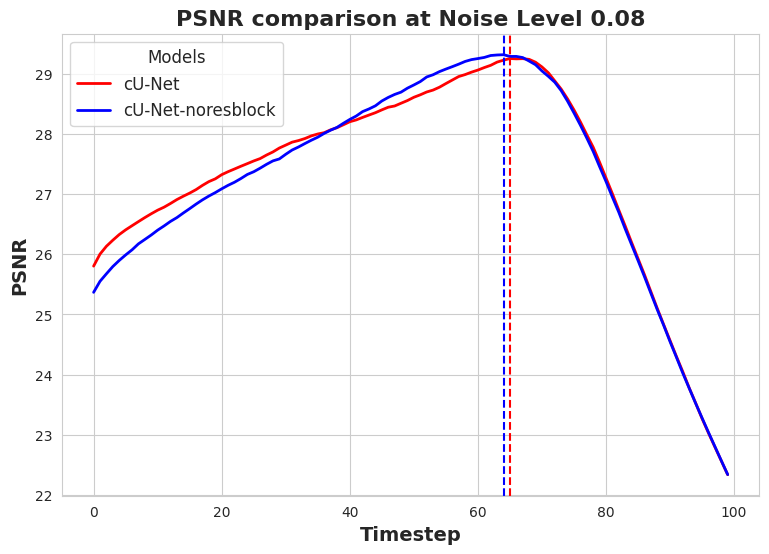

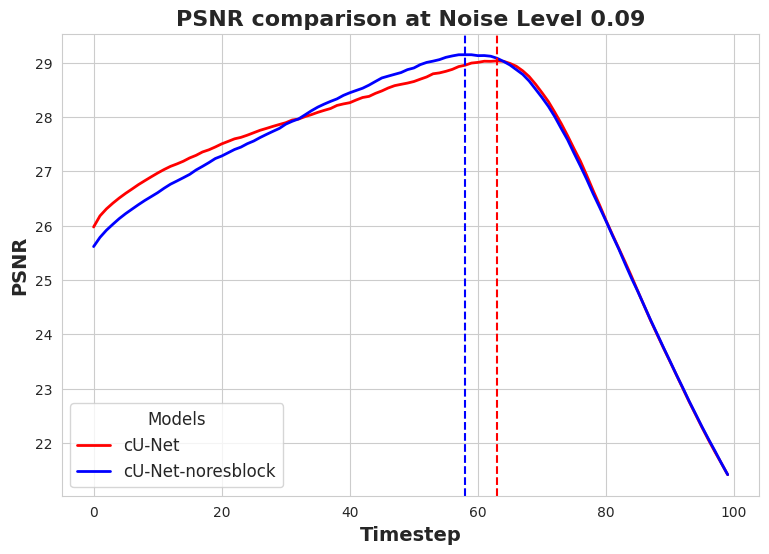

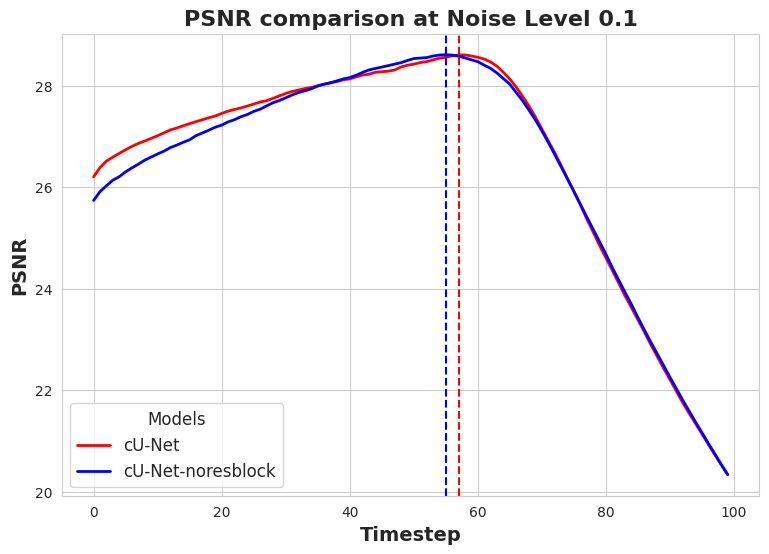

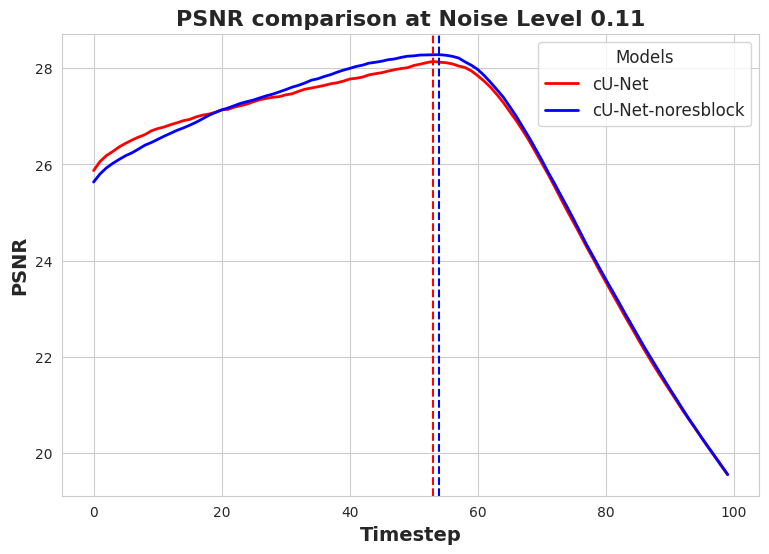

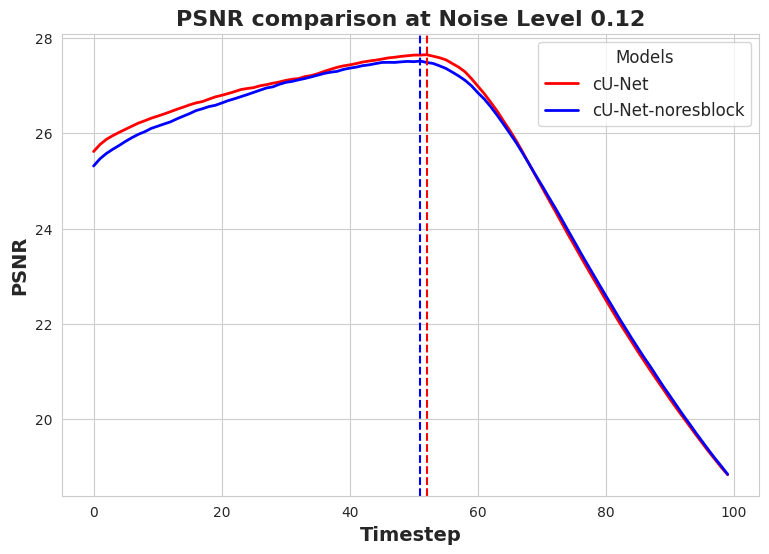

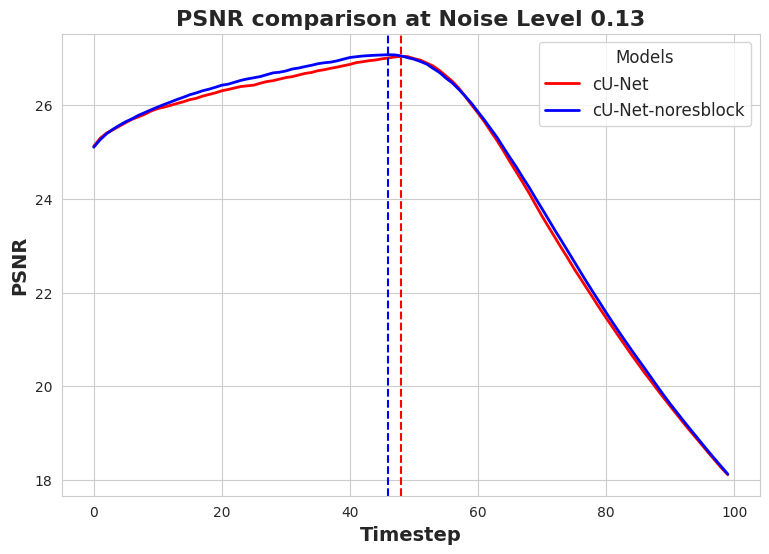

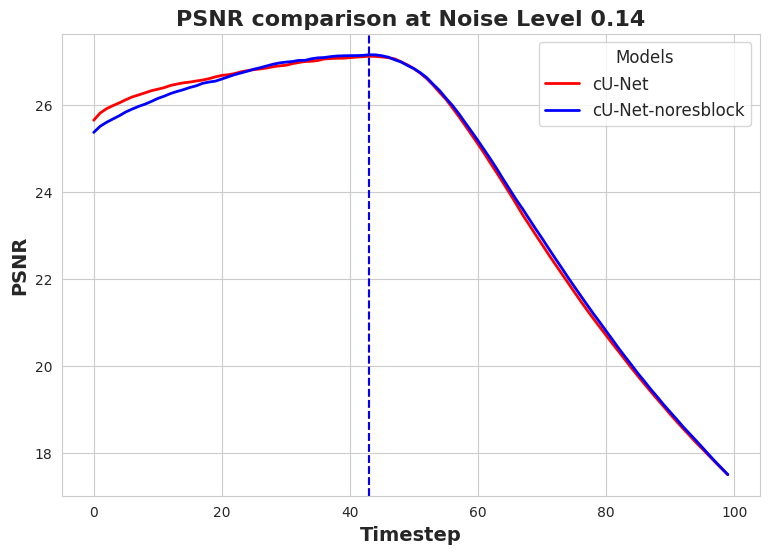

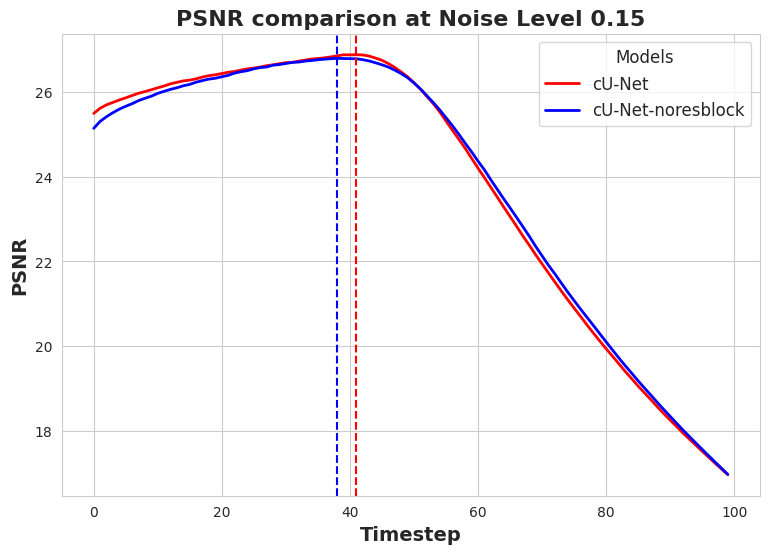

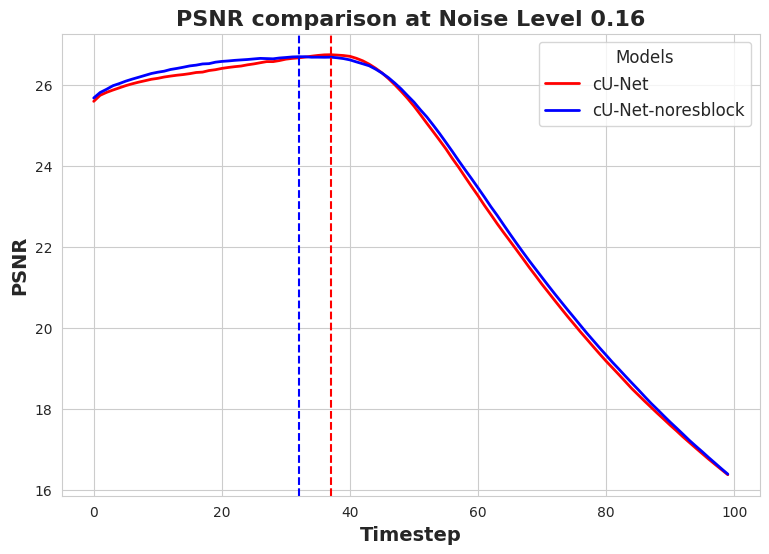

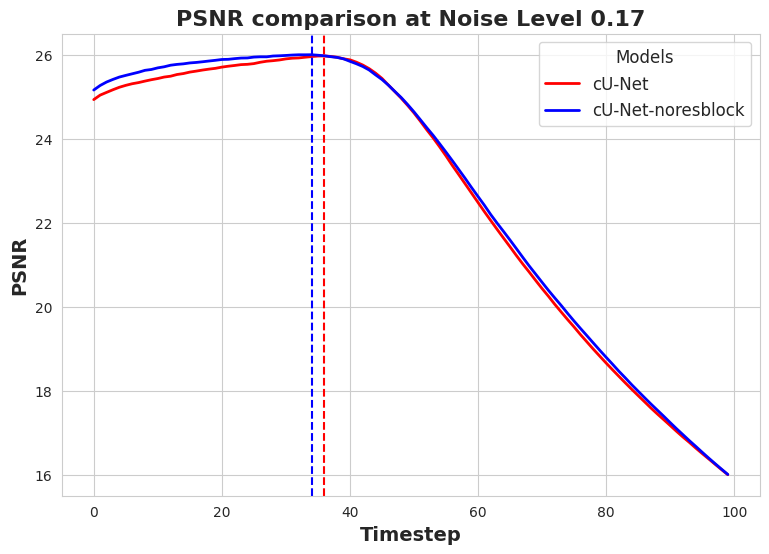

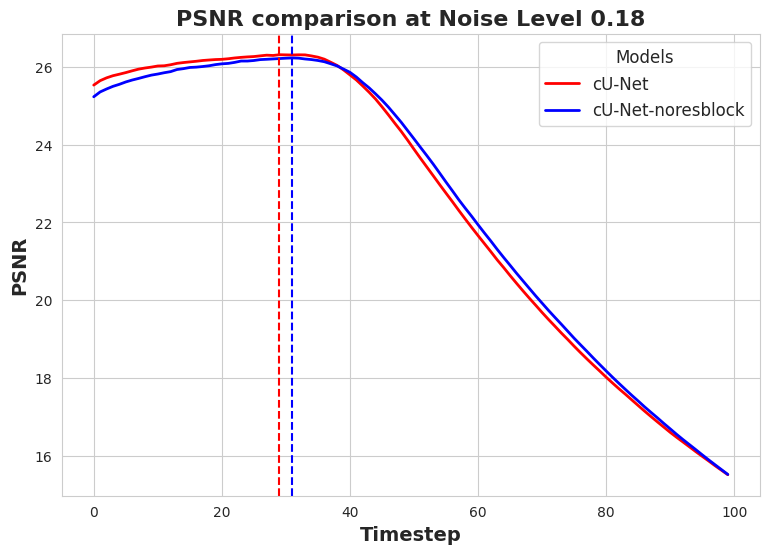

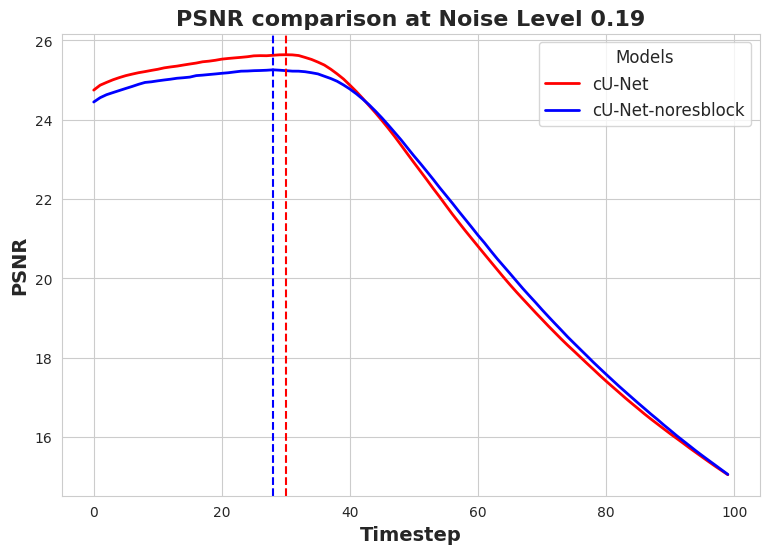

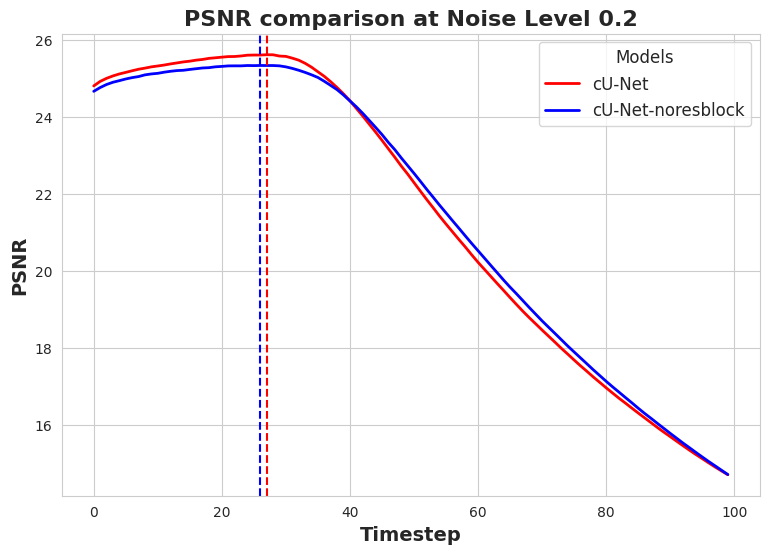

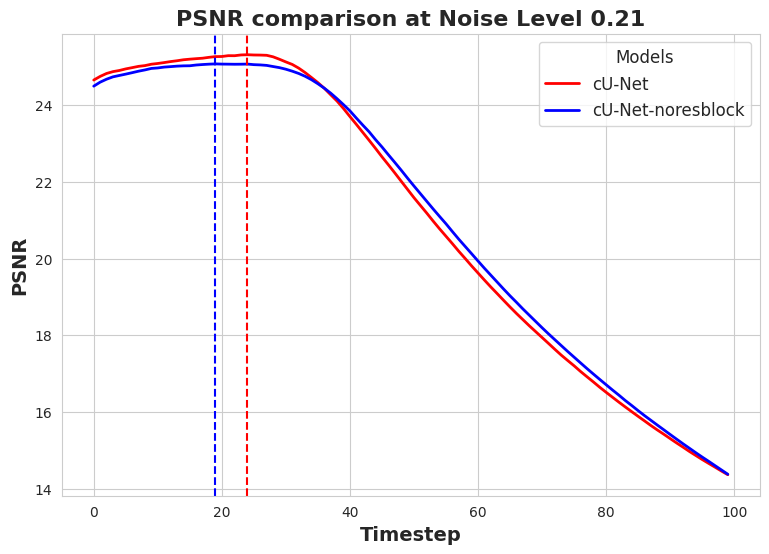

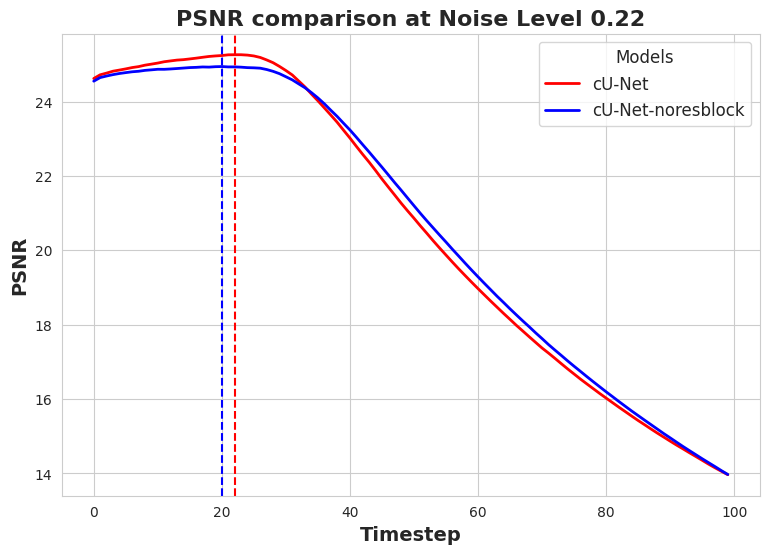

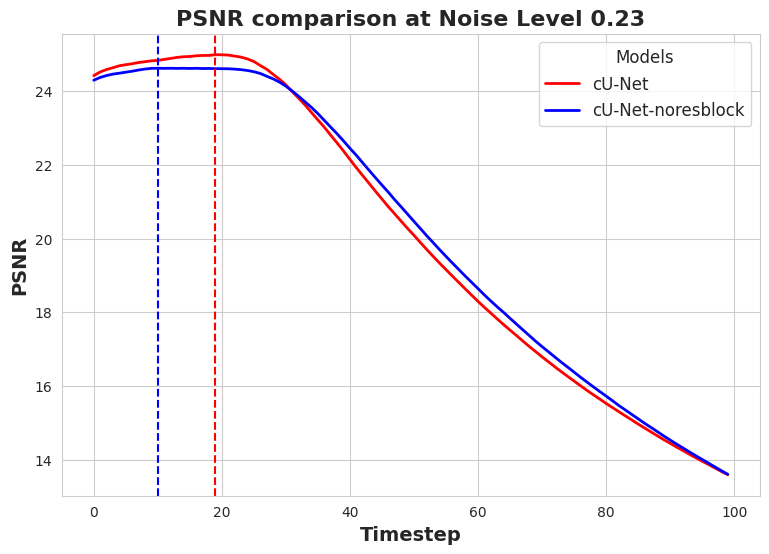

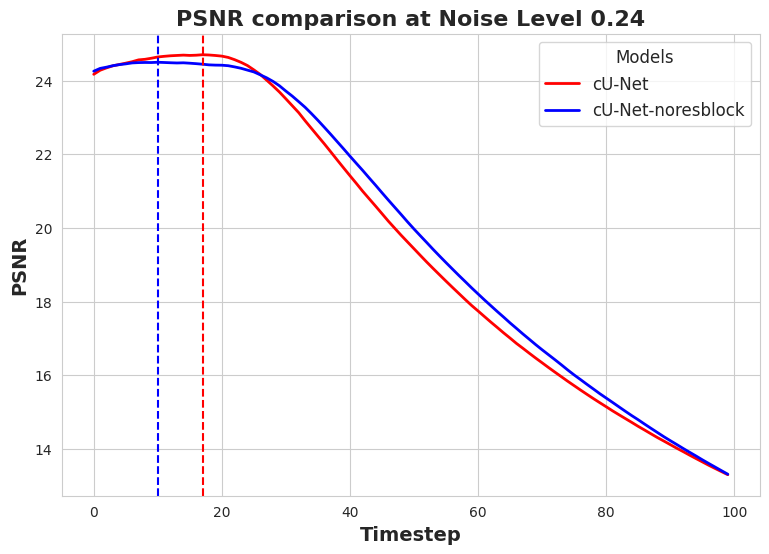

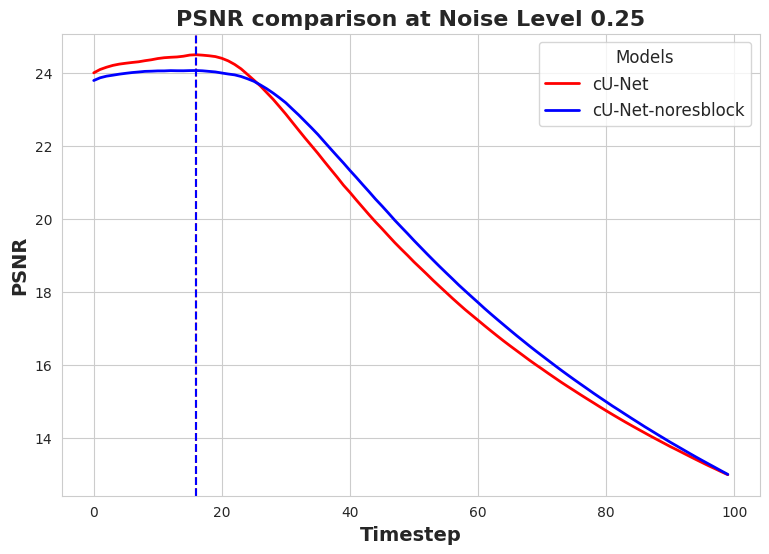

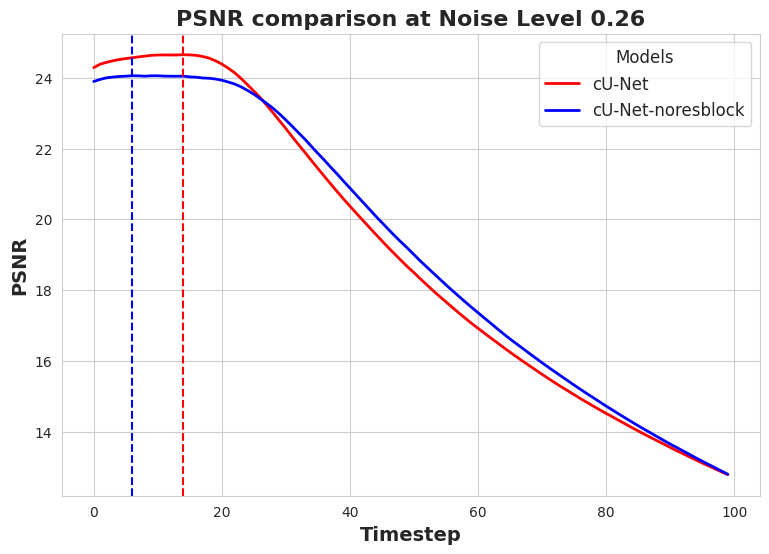

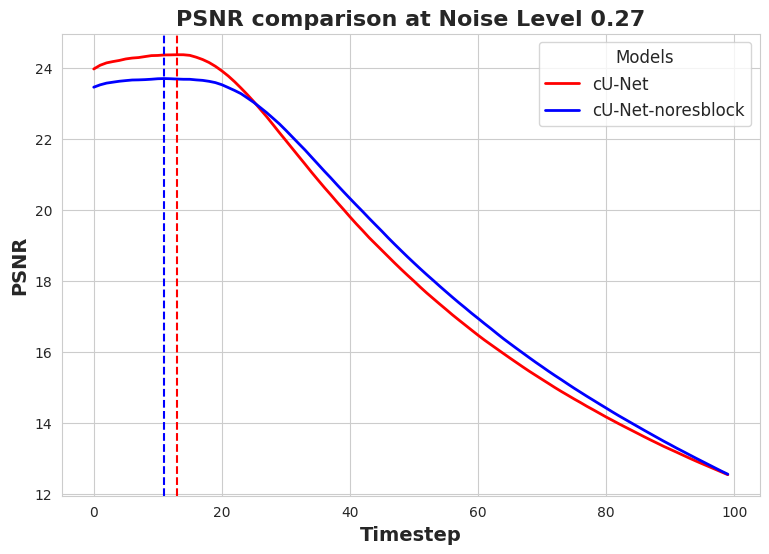

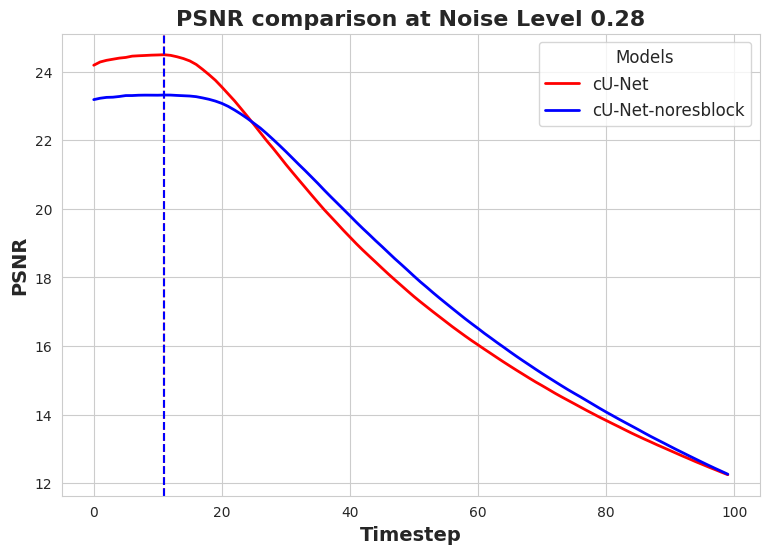

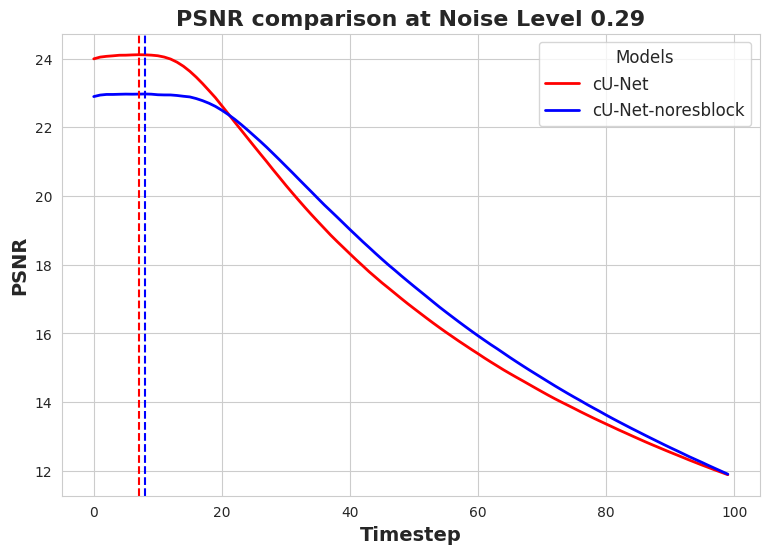

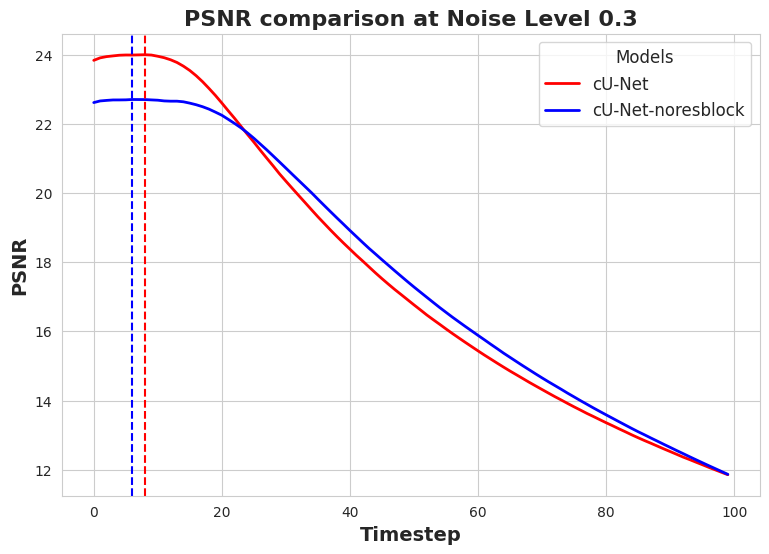

In [ ]:
# Suppress FutureWarning and UserWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Load the image
image_path = "img_align_celeba/135013.jpg"
image = Image.open(image_path)
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0)

# Add noise
eps_list = np.round(np.arange(0.01, 0.31, 0.01), 2) #np.arange(0.01, 0.21, 0.01)

for eps in eps_list:
  noise = torch.randn_like(image_tensor) * eps
  noisy_image = image_tensor + noise
  # noisy_image = torch.clamp(noisy_image, 0, 1) # check

  # Initialize metrics dataframe
  metrics_df = pd.DataFrame(columns=["Step","PSNR"])
  metrics_df_2 = pd.DataFrame(columns=["Step","PSNR"])

  # Define timesteps
  total_timesteps = 100

  # Denoising
  with torch.no_grad():
      current_image = noisy_image
      current_image_2 = noisy_image
      for t in reversed(range(total_timesteps)):
          t_tensor = torch.tensor([t], dtype=torch.long)

          start_time = time.time()  # track start time
          model_mean, _, _, _ = diffusion.p_mean_variance(current_image, t_tensor)
          end_time = time.time()  # track end time

          start_time_2 = time.time()  # track start time
          model_mean_2, _, _, _ = diffusion_2.p_mean_variance(current_image_2, t_tensor)
          end_time_2 = time.time()  # track end time

          current_image = torch.normal(mean=model_mean, std=torch.ones_like(model_mean) * 0.005)
          current_image_2 = torch.normal(mean=model_mean_2, std=torch.ones_like(model_mean_2) * 0.005)

          # Convert to numpy and transpose for metrics computation
          current_image_np = np.transpose(current_image.squeeze().cpu().numpy(), (1, 2, 0))
          current_image_np_2 = np.transpose(current_image_2.squeeze().cpu().numpy(), (1, 2, 0))

          original_image_np = np.transpose(image_tensor.squeeze().cpu().numpy(), (1, 2, 0))

          # Compute PSNR
          psnr = metrics.peak_signal_noise_ratio(original_image_np, current_image_np, data_range=1)
          psnr_2 = metrics.peak_signal_noise_ratio(original_image_np, current_image_np_2, data_range=1)

          # Append to dataframe
          metrics_df = metrics_df.append({"Step": t, "PSNR": psnr, "Time": end_time - start_time}, ignore_index=True)  # add time data
          metrics_df_2 = metrics_df_2.append({"Step": t, "PSNR": psnr_2, "Time": end_time_2 - start_time_2}, ignore_index=True)  # add time data

  # Get steps where metrics are maximized
  best_psnr_step = metrics_df.loc[metrics_df['PSNR'].idxmax()]['Step']
  best_psnr_step_2 = metrics_df_2.loc[metrics_df_2['PSNR'].idxmax()]['Step']

  # Calculate cumulative time
  cumulative_time = metrics_df["Time"].sum()
  cumulative_time_2 = metrics_df_2["Time"].sum()

  # Time to best PSNR
  time_to_best_psnr = metrics_df.loc[metrics_df['PSNR'].idxmax()]['Time']
  time_to_best_psnr_2 = metrics_df_2.loc[metrics_df_2['PSNR'].idxmax()]['Time']

  # Create dataframe to store best values and corresponding steps
  best_df = pd.DataFrame({
      "Best PSNR Value": [metrics_df['PSNR'].max()],
      "Best PSNR Step": [best_psnr_step],
      "Total Time (s)": [cumulative_time],
      "Time to Best PSNR (s)": [time_to_best_psnr],
      "Noise Level": eps,
      "Model ID": "cU-Net", # Change according to the experiment
  })

  best_df_2 = pd.DataFrame({
      "Best PSNR Value": [metrics_df_2['PSNR'].max()],
      "Best PSNR Step": [best_psnr_step_2],
      "Total Time (s)": [cumulative_time_2],
      "Time to Best PSNR (s)": [time_to_best_psnr_2],
      "Noise Level": eps,
      "Model ID": "cU-Net-noresblock", # Change according to the experiment
  })

  # File path
  file_path = 'comparison_data.csv'
  append_df = pd.concat([best_df, best_df_2], ignore_index=True)

  # Check if file exists
  if os.path.isfile(file_path):
      # If it exists, load it and append new data
      existing_df = pd.read_csv(file_path, index_col=0)
      updated_df = pd.concat([existing_df, append_df], ignore_index=True)
  else:
      # If it does not exist, use the current data
      updated_df = append_df

  # Save the updated dataframe to csv
  updated_df.to_csv(file_path)

  # Set the aesthetic style of the plots
  sns.set_style("whitegrid")

  # Initialize the matplotlib figure
  f, ax = plt.subplots(figsize=(9, 6))

  # Melt dataframes manually without 'Time' column
  melted_df = pd.melt(metrics_df[['Step', 'PSNR']], ['Step'])
  melted_df_2 = pd.melt(metrics_df_2[['Step', 'PSNR']], ['Step'])

  # Plot the metrics with specific colors and labels
  sns.lineplot(x="Step", y="value", hue="variable", data=melted_df, ax=ax, palette=["red"], linewidth=2, label="cU-Net")
  sns.lineplot(x="Step", y="value", hue="variable", data=melted_df_2, ax=ax, palette=["blue"], linewidth=2, label="cU-Net-noresblock")

  # Add vertical lines at the steps with best PSNR for each model
  ax.axvline(x=best_psnr_step, color='red', linestyle='--')
  ax.axvline(x=best_psnr_step_2, color='blue', linestyle='--')

  # Set labels and title
  ax.set_xlabel('Timestep', fontsize=14, fontweight="bold")
  ax.set_ylabel('PSNR', fontsize=14, fontweight="bold")
  ax.set_title(f'PSNR comparison at Noise Level {np.round(eps, 2)}', fontsize=16, fontweight="bold")

  # Customize the legend
  handles, labels = ax.get_legend_handles_labels()
  filtered_handles = []
  filtered_labels = []
  for handle, label in zip(handles, labels):
      if label != "PSNR":
          filtered_handles.append(handle)
          filtered_labels.append(label)

  ax.legend(handles=filtered_handles, labels=filtered_labels, title="Models", fontsize=12, title_fontsize=12)

  # Save the figure
  plt.savefig(f'results/noise_level_{eps}.png', dpi=300)

  # Show the plot
  plt.show()

# Reset to default warning behavior
warnings.resetwarnings()

In [ ]:
best_df # red

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best PSNR Value  Best PSNR Step  Total Time (s)  Time to Best PSNR (s)  \
0        29.205528            66.0        7.970462               0.083277   

   Noise Level  
0         0.08

In [ ]:
best_df_2 # blue

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best PSNR Value  Best PSNR Step  Total Time (s)  Time to Best PSNR (s)  \
0        29.178981            64.0        9.933617               0.087435   

   Noise Level  
0         0.08

## Classical Denoising methods

PSNR (Median Filter):  24.99190578479025
PSNR (Gaussian Filter):  25.987844921571938


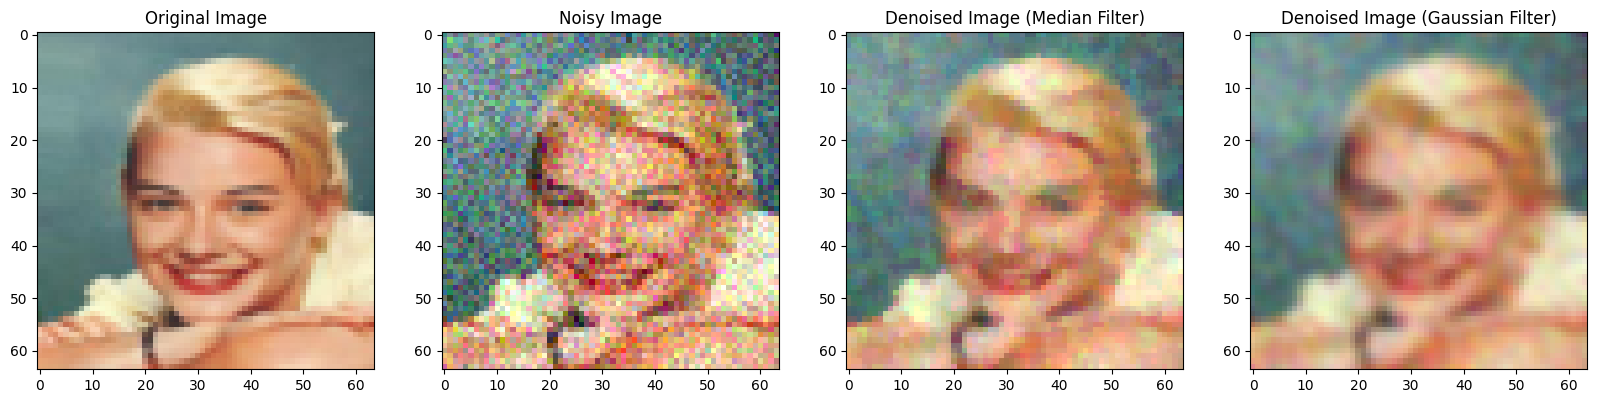

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
from skimage.filters import median, gaussian
from skimage.morphology import square
from skimage import metrics
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "img_align_celeba/135013.jpg"
image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

# Apply the transformation
image_tensor = transform(image).unsqueeze(0)

# Add noise
eps = 0.1
noise = torch.randn_like(image_tensor) * eps
noisy_image = image_tensor + noise
noisy_image = torch.clamp(noisy_image, 0, 1)

# Convert the noisy image back to a numpy array for filtering
noisy_image_np = noisy_image.squeeze(0).permute(1, 2, 0).numpy()

# Apply the median filter to each color channel separately
filtered_image_np_median = np.zeros_like(noisy_image_np)
for i in range(3):
    filtered_image_np_median[..., i] = median(noisy_image_np[..., i], square(3))

# Apply the Gaussian filter to each color channel separately
filtered_image_np_gaussian = np.zeros_like(noisy_image_np)
for i in range(3):
    filtered_image_np_gaussian[..., i] = gaussian(noisy_image_np[..., i], sigma=1)

# Convert the filtered images back to tensors
filtered_image_median = torch.from_numpy(filtered_image_np_median).permute(2, 0, 1).unsqueeze(0)
filtered_image_gaussian = torch.from_numpy(filtered_image_np_gaussian).permute(2, 0, 1).unsqueeze(0)

# Compute the PSNR of the original and denoised images
psnr_median = metrics.peak_signal_noise_ratio(image_tensor.numpy(), filtered_image_median.numpy(), data_range=1)
psnr_gaussian = metrics.peak_signal_noise_ratio(image_tensor.numpy(), filtered_image_gaussian.numpy(), data_range=1)

print("PSNR (Median Filter): ", psnr_median)
print("PSNR (Gaussian Filter): ", psnr_gaussian)

# Plot the original, noisy, and denoised images
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(image_tensor.squeeze(0).permute(1, 2, 0))
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(noisy_image_np)
plt.title('Noisy Image')

plt.subplot(1, 4, 3)
plt.imshow(filtered_image_np_median)
plt.title('Denoised Image (Median Filter)')

plt.subplot(1, 4, 4)
plt.imshow(filtered_image_np_gaussian)
plt.title('Denoised Image (Gaussian Filter)')

plt.show()

## Loss plot

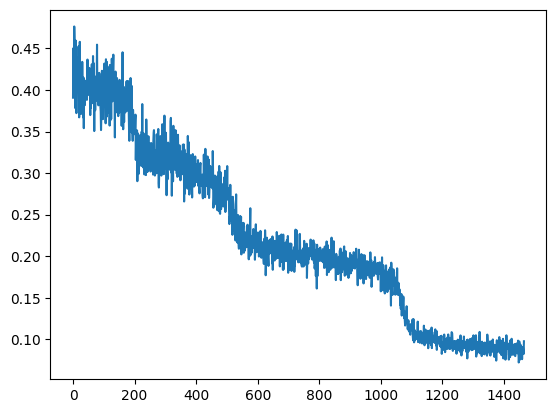

In [ ]:
# Load and plot loss curve:
import pickle

# Reading the list of losses from the file
with open('losses.pkl', 'rb') as file:
    losses = pickle.load(file)

# Now you have the losses list and you can work with it
plt.plot(np.arange(0, len(losses), 1), losses)
plt.show()

## Train U-Net

In [ ]:
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Lambda, Resize
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True
)

diffusion = GaussianDiffusion(
    model,
    image_size = 64,
    timesteps = 1000,           # number of steps
    sampling_timesteps = 250    # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
)

trainer = Trainer(
    diffusion,
    "cifar10/train",
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = 7000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
    calculate_fid = False              # whether to calculate fid during training
)

trainer.train()

sampled_images = diffusion.sample(batch_size = 4)
sampled_images = sampled_images.to("cpu")

# Plot the images
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axs[i].imshow(sampled_images[i].permute(1, 2, 0))
    axs[i].axis('off')

# Display the plot
plt.show()

### Load the saved model with the custom method in Trainer and sample many images

In [ ]:
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer

#model = ConvSODEUNet(n_steps=1000)

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True
)

# Initialize the GaussianDiffusion with the trained model
diffusion = GaussianDiffusion(
    model,
    image_size = 64,
    timesteps = 1000,
    sampling_timesteps = 7
)

# Instantiate the trainer and pass the diffusion model
trainer = Trainer(
    diffusion,
    "img_align_celeba",
    train_batch_size=128,
    train_lr=2e-4,
    train_num_steps=10000,
    gradient_accumulate_every=2,
    ema_decay=0.9999,
    amp=True,
    calculate_fid=False
)

# Load the desired model
milestone = 500  # Specify the milestone or identifier of the saved model
trainer.load(milestone)
# Access the loaded model
loaded_model = trainer.model
loaded_model = loaded_model.cpu()

loading from version 1.8.3


In [ ]:
for i in range(100):
  sample_image = diffusion.sample(batch_size = 1)

  fig = plt.figure(figsize=(3, 2))
  plt.imshow(sample_image[0].permute(1, 2, 0))
  plt.axis('off')
  plt.show()

## Grab 8 images at random from the dataset, resize and plot

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Set the path to the image folder
image_folder = "img_align_celeba"

# Get a list of all image filenames in the folder
image_files = os.listdir(image_folder)

# Shuffle the image files randomly
random.shuffle(image_files)

# Select the first 8 images
selected_images = image_files[:8]

# Loop through the selected images and plot them
for i, image_file in enumerate(selected_images):
    # Create a new figure for each image
    fig = plt.figure(figsize=(3, 2))

    # Load and resize the image
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path).resize((64, 64))

    # Plot the image
    plt.imshow(image)
    plt.axis('off')

    # Display the plot
    plt.show()

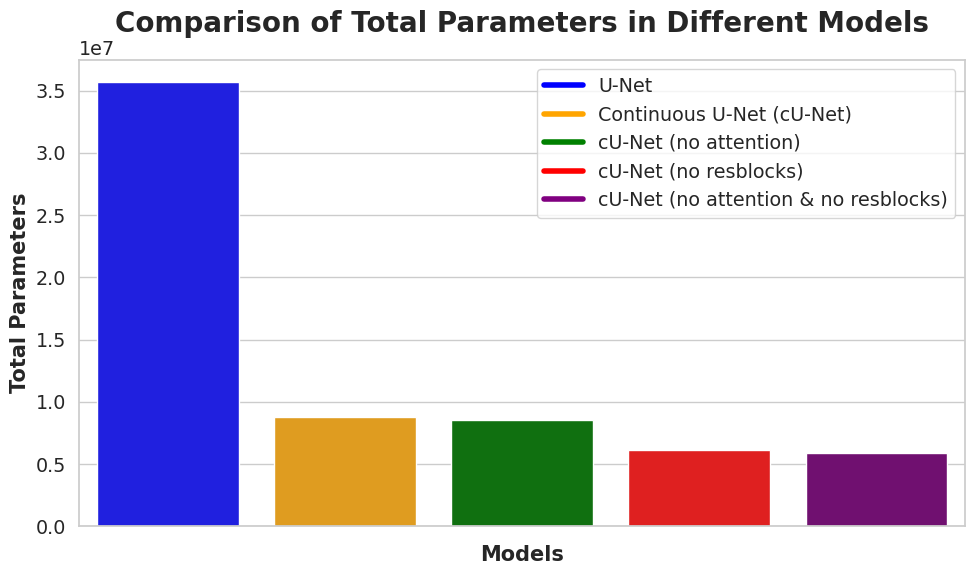

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data
models = ['U-Net', 'Continuous U-Net (cU-Net)', 'cU-Net (no attention)', 'cU-Net (no resblocks)', 'cU-Net (no attention & no resblocks)']
parameters = [35710339, 8811875, 8548707, 6138083, 5874915]

# Create a DataFrame
df = pd.DataFrame({'Models': models, 'Total Parameters': parameters})

# Set style and context to make the plot look more aesthetically pleasing
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

# Create bar plot
plt.figure(figsize=(10,6))
colors = ['blue', 'orange', 'green', 'red', 'purple']
barplot = sns.barplot(x='Models', y='Total Parameters', data=df, palette=colors)

# Add title and labels with bold font
plt.title('Comparison of Total Parameters in Different Models', weight='bold', size=20)
plt.ylabel('Total Parameters', weight='bold')
plt.xlabel('Models', weight='bold')

# Remove x-axis labels
barplot.set(xticklabels=[])

# Create legend manually
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) for color, label in zip(colors, models)]
plt.legend(handles=legend_elements, loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

# **TO-DOs:**

1. Try a commonly used denoising dataset.
2. Run experiments with cUNet without attention/without attention + res connections/without res connections
3. CelebA 64x64 seems to be getting the shape of the head much better than 256x256 celeba-hq model. Might be because of the position of the attention within the model? Try to move the attention of the celeba-64 model to the middle layer and see if anything changes.
4. Check if the fact that for each downsampling and upsampling blocks there are **2 ResNet blocks** is important.

---------------------------------------------------
* Increase **batch size** and check if it's a big difference. **(DONE: Now batch size 128)**
* Change **learning rate** to the one given in the DDPM paper (2e-4 - 2e-5 for 256x256 images). **(DONE)**
* Test a more appropriate **time embedding** **(DONE: Using dim 256 like original UNet)**
* Changed **conv_2 layer in convSODEFunc** to from kernel size 1 to 3 and padding 0 to 1. **(DONE)**
* Implemented **contribution** skip connections, residual, and time embedding naturally into ODEBlock. **(DONE)**
* Check if **attention is properly implemented** in cUNet. **(DONE: it seems that in the official implementation for the UNet there is one attention layer for each downsampling and upsampling block as well as in the bottleneck)**
* Check if model is being **saved appropriately.** **(DONE: had to use the the load method built in Trainer class)**
* **Track training loss** **(DONE: tracking the average loss every 1000 training steps and saving it as a pickle file)**
* Add **data augmentations** (random horizontal flips). Paper claims that it improves sample quality slightly. **(DONE: codebase already includes data augmentations)**
* Get rid of self.te_1 **(DONE)**
* Check modifications required to train the diffusion model with **CelebA HQ.** -> 6 feature map resolutions (instead of 4), batch size = 64, sampling timesteps (?) to 128, 0.5M training steps, learning rate to 2e10-5. **(DONE)**
* Use pretrained model from colab in HPC, milestone 10. Prepare the code to handle that.**(DONE: Currently using milestone 250 (50% training). Had to change Adam optimiser parameter capturable=True)**
* **Implement denoising** - I don't understand what's the difference (basic idea is to condition the denoising with a validation image and then compare it to the output of the denoising model. But changing the reverse process/sampling??). **(DONE: The difficulty was basically in loading the model and understanding what t should be)**
* Track **inference time** for the same number of steps **(DONE)**
* Compute **quality metrics** for denoising **(DONE: Tracking them in a csv file already)**
* Make it work with celebA (64x64) **(DONE: 40+ hour training ongoing)**
* Compare how many steps are required to achieve best PSNR/SSIM values for UNet and cUNet - we expect cUNet to achieve this much earlier.
* Check if **less denoising steps** are required for cUNet
* It seems like UNet got worse performance after more training steps (check this more thoroughly). Check if maybe it's the case for cUNet too. **(DONE: cUNet performance also went down after 100000 iterations)**
* Plot in the same axis PSNR for cUNet and UNet. **(DONE: As expected cU-Net works better than U-Net and it's faster. However, results are not as good as in experiments before)**
* Check if even though cUNet takes more steps to converge to a (better) solution, the overall time is more or less than the conventional UNet. Track the time until the peak performance is achieved, one could do this by tracking the cumulative time at each step. **(DONE: there is not the big mismatch between steps to peak performance as in previous experiments)**
* Check if, for the same (and reduced) number of steps that takes the UNet to converge, the cUNet can achieve a similar or better/worse performance. **(DONE: tracking times until peak performance makes up for this)**
* Investigate why results are different **(DONE: Fixed, it was a bug. cU-Net is much better than baseline U-Net)**
* Re-Do tables **(Done: Really, only the last table is key. The rest of the tables are fine, the mistake was in the new experiment)**
* Implement traditional denoising methods (e.g. Gaussian smoothing, median filtering) **(DONE: Was straightforward using skimage filters)**
* Read "Diffusion Model for Generative Image Denoising" and understand different training process for different noise distributions. **(DONE: Did not read the whole paper but they propose an alternative diffusion procedure tailored towards denoising. This is not applicable to our research)**
* Train model for different types of noise (e.g. poisson or gamma). **(Seems like it won't be a good idea)**
* Implement another deep learning-based denoising technique for benchmarking. **(DONE: Implemented Convolutional Autoencoder.)**
* Implement classical denoising techniques, i.e. that don't involve machine learning **(DONE: Implemented Median Filtering and Gaussian Smoothing)**


### Comments:
- No resblock model seems to even outperform the complete model in denoising (for some noise levels). Doesn't seem to be he case for image synthesis.

### Resizing images

In [ ]:
from PIL import Image
import os

#input_folders = ["train/daisy", "train/dandelion", "train/rose", "train/rose",
#                 "train/sunflower", "train/tulip"]
#input_folders = ["cifar10/train/airplane", "cifar10/train/automobile",
                #  "cifar10/train/bird", "cifar10/train/cat",
                #  "cifar10/train/deer", "cifar10/train/dog",
                #  "cifar10/train/frog", "cifar10/train/horse",
                #  "cifar10/train/ship", "cifar10/train/truck"]
input_folders = ["img_align_celeba"]


output_size = (64, 64)

for input_folder in input_folders:
    # Delete the Thumbs.db file if it exists
    thumbs_db_path = os.path.join(input_folder, "Thumbs.db")
    if os.path.exists(thumbs_db_path):
        os.remove(thumbs_db_path)

    for filename in os.listdir(input_folder):
        file_path = os.path.join(input_folder, filename)

        # Check if it is a file (and not a directory)
        if os.path.isfile(file_path):
            try:
                # Open the image
                with Image.open(file_path) as im:
                    # Verify the image
                    im.verify()

                # Check if the image size matches the target size
                im = Image.open(file_path)
                image_size = im.size
                if image_size != output_size:
                    # Resize the image
                    im_resized = im.resize(output_size, Image.ANTIALIAS)

                    # Save the resized image back to the original file
                    im_resized.save(file_path)

            except:
                # If an error is thrown, it's probably a bad image, delete it
                print(f"Deleting corrupted image: {file_path}")
                os.remove(file_path)

print("Images have been processed")

Images have been processed


## Get a random image from a folder and check the size

In [ ]:
import os
from PIL import Image

folder_path = "cifar10/train/airplane"

# Get a list of image file names in the folder
image_names = os.listdir(folder_path)

# Choose a random image from the list
random_image_name = image_names[10]  # Change this line to select a different random image

# Construct the path to the random image
random_image_path = os.path.join(folder_path, random_image_name)

# Open the image using PIL
image = Image.open(random_image_path)

# Get the size of the image
image_size = image.size

print(f"Image size: {image_size}")

Image size: (64, 64)


### Delete corrupted and != 3 channel images

In [ ]:
from PIL import Image
import os

input_folders = ["train/daisy", "train/dandelion", "train/rose", "train/rose",
                 "train/sunflower", "train/tulip"]

for folder in input_folders:
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)

        # Check if it is a file (and not a directory)
        if os.path.isfile(file_path):
            try:
                # Open the image
                with Image.open(file_path) as im:
                    # Verify the image
                    im.verify()

            except:
                # If an error is thrown, it's probably a bad image, delete it
                print(f"Deleting corrupted image: {file_path}")
                os.remove(file_path)

print("Corrupted images have been deleted")

In [ ]:
from PIL import Image
import numpy as np
import os

input_folders = ["img_align_celeba"]
target_size = (64, 64, 3)

for input_folder in input_folders:
    for filename in os.listdir(input_folder):
        file_path = os.path.join(input_folder, filename)

        # Check if it is a file (and not a directory)
        if os.path.isfile(file_path):
            # Check if the image size matches the target size
            img_np = np.asarray(Image.open(file_path)).shape

            if img_np != target_size:
                # Delete the image if it doesn't have the target size
                print(f"Deleting image with incorrect size: {file_path}")
                os.remove(file_path)

print("Incorrectly sized images have been deleted")

Incorrectly sized images have been deleted


### Count images in the folder

In [ ]:
import os

#folder_path = "PetImages/Cat"
folder_path = "img_align_celeba"

# Get the list of image file names in the folder
image_names = os.listdir(folder_path)

# Count the number of image files
num_images = len(image_names)

print("Number of images in the folder:", num_images)

# Normally 12500 - should be 12470

Number of images in the folder: 202599


## Setup Kaggle API

In [ ]:
# Gotta upload kaggle.json
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/

## MNIST dataset

In [ ]:
!kaggle datasets download -d scolianni/mnistasjpg

In [ ]:
!unzip mnistasjpg.zip

## Flowers dataset

In [ ]:
!kaggle datasets download -d imsparsh/flowers-dataset

In [ ]:
!unzip flowers-dataset.zip

## CIFAR-10 dataset

In [ ]:
# Download cifar10 dataset
!kaggle datasets download -d oxcdcd/cifar10

In [ ]:
!unzip cifar10.zip

## CelebA-HQ dataset

In [ ]:
# Download celebA-HQ dataset
!kaggle datasets download -d badasstechie/celebahq-resized-256x256

In [ ]:
!unzip celebahq-resized-256x256.zip

## CelebA dataset

In [ ]:
!kaggle datasets download -d ahmedshawaf/celeba

100% 1.31G/1.32G [01:02<00:00, 22.9MB/s]
100% 1.32G/1.32G [01:02<00:00, 22.8MB/s]


In [ ]:
!unzip celeba.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/197600.jpg  
  inflating: img_align_celeba/197601.jpg  
  inflating: img_align_celeba/197602.jpg  
  inflating: img_align_celeba/197603.jpg  
  inflating: img_align_celeba/197604.jpg  
  inflating: img_align_celeba/197605.jpg  
  inflating: img_align_celeba/197606.jpg  
  inflating: img_align_celeba/197607.jpg  
  inflating: img_align_celeba/197608.jpg  
  inflating: img_align_celeba/197609.jpg  
  inflating: img_align_celeba/197610.jpg  
  inflating: img_align_celeba/197611.jpg  
  inflating: img_align_celeba/197612.jpg  
  inflating: img_align_celeba/197613.jpg  
  inflating: img_align_celeba/197614.jpg  
  inflating: img_align_celeba/197615.jpg  
  inflating: img_align_celeba/197616.jpg  
  inflating: img_align_celeba/197617.jpg  
  inflating: img_align_celeba/197618.jpg  
  inflating: img_align_celeba/197619.jpg  
  inflating: img_align_celeba/197620.jpg  
  inflating: img_align_celeba/197621.jpg  
  i

In [ ]:
!rm celeba.zip

## Download Models from Google Drive

In [ ]:
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io
from google.colab import auth

# Authenticate and create the drive service
auth.authenticate_user()
drive_service = build('drive', 'v3')

# file_id = '1j8_yV4PVxn4_6VK-lhTmDNlzNGbqi9JJ' # Model 100 unet
# file_id = '1eIJBHleHfAYovzTEgHN1czPLuDkXZSLP' # Model 375 unet
file_id = '1Z79AeB4_DmQgdrsk3rHxVfsR8P-IH6yg' # Model 500 unet
# file_id = '1NabJVQlydJUFSMew61-uA-K61JMrWCWV' # Model 125 cunet
# file_id = '1QMmfo8nfLw1HTZ8x06c6I7_nzzZ3HlPm' # Model 500 cunet
# file_id = '1OAeOPRbJl5km8d7ZzYKYhXBj1i722Hdy' # Model 125 no attn
# file_id = '1JBga4E00aqIWNTL0ezVpaZwBtIo1GTBB' # Model 125 no resblocks

request = drive_service.files().get_media(fileId=file_id)
fh = io.BytesIO()

# Perform the download
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download progress: {}%".format(int(status.progress() * 100)))

# Save the downloaded file
with open('model-125.pt', 'wb') as f:
    f.write(fh.getvalue())

Download progress: 18%
Download progress: 36%
Download progress: 54%
Download progress: 73%
Download progress: 91%
Download progress: 100%


## Gamma noise

Solver: rk4
loading from version 1.8.3


/usr/local/lib/python3.10/dist-packages/torchdiffeq/_impl/misc.py:11: UserWarning: RK4: Unexpected arguments {'max_num_steps': 1000}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


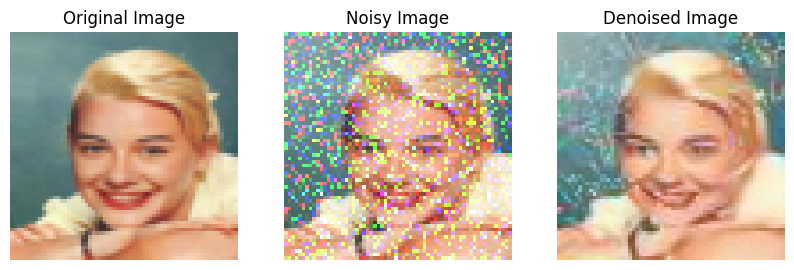

<ipython-input-232-1a68e195dc0d>:149: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"MSE": mse, "PSNR": psnr, "SSIM": ssim,


MSE       PSNR      SSIM  Noise Level  Nº of Timesteps  Elapsed Time
0   0.202405   6.937797  0.351954      0.10000             40.0      3.097300
1   0.196302   7.070746  0.348861      0.10000             40.0      3.536093
2   0.194385   7.113373  0.346798      0.10000             40.0      3.083071
3   0.193960   7.122874  0.378471      0.00100             40.0      3.098127
4   0.001583  28.004549  0.918200      0.00001             40.0      3.025040
5   0.009623  20.166910  0.902640      0.00010             40.0      3.011958
6   0.195051   7.098516  0.372029      0.00100             40.0      3.634940
7   0.140973   8.508642  0.563013      0.00050             40.0      3.103340
8   0.001516  28.193858  0.922675      0.00020             40.0      3.036567
9   0.001547  28.105370  0.919406      0.00200             40.0      3.492611
10  0.009116  20.401992  0.879974      0.02000             40.0      3.337240
11  0.059795  12.233338  0.647992      0.10000             40.0      3.074819
12  0.009529  20.209356  0.790294      0.10000             40.0      3.089154

In [ ]:
import torch
import pandas as pd
from skimage import metrics
import os
import time
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from denoising_diffusion_pytorch import GaussianDiffusion, Trainer

# Load the model (assuming you have already trained it)
model = ConvSODEUNet(n_steps=1000)

# Initialize the GaussianDiffusion with the trained model
diffusion = GaussianDiffusion(
    model,
    image_size = 64,
    timesteps = 1000,
    sampling_timesteps = 256
)

# Instantiate the trainer and pass the diffusion model
trainer = Trainer(
    diffusion,
    "img_align_celeba",
    train_batch_size=128,
    train_lr=2e-4,
    train_num_steps=10000,
    gradient_accumulate_every=2,
    ema_decay=0.9999,
    amp=True,
    calculate_fid=False
)

# Load the desired model
milestone = 500  # Specify the milestone or identifier of the saved model
trainer.load(milestone)

# Access the loaded model
model = trainer.model
model = model.cpu()

# Ensure the model is in evaluation mode
model.eval()

# Assuming you have a noisy_image tensor with shape [batch_size, channels, height, width]
# Load the image
image_path = "img_align_celeba/135013.jpg" #"test/Image_8.jpg"
image = Image.open(image_path)

# Define the transformations: resize and convert to tensor
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # assuming that your model expects 64x64 images
    transforms.ToTensor(),
])

# Apply transformations
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Add noise to the image
eps = 0.1
# noise = torch.randn_like(image_tensor) * eps
# 0.4 -> ~84 timesteps
# 0.2 -> ~55 timesteps

# Add Gamma noise to the image
shape_parameter = 0.1  # You can adjust this
scale_parameter = 0.05  # You can adjust this
gamma_dist = torch.distributions.Gamma(shape_parameter, scale_parameter)
noise = gamma_dist.sample(image_tensor.shape) * eps

noisy_image = image_tensor + noise

# Ensure the values are between 0 and 1 after adding noise
noisy_image = torch.clamp(noisy_image, 0, 1)

# Generate the noise schedule (you can adjust the number of sampling steps)
num_timesteps = 40

start_time = time.time()

# Perform the denoising task
with torch.no_grad():
    # Condition the model on the noisy image and sample in the reverse process
    # x -> denoised image tensor
    current_image = noisy_image
    for t in reversed(range(num_timesteps)):
        t_tensor = torch.tensor([t], dtype=torch.long)
        model_mean, _, _, _ = diffusion.p_mean_variance(current_image, t_tensor)
        current_image = torch.normal(mean=model_mean, std=torch.ones_like(model_mean) * 0.005)  # You can adjust the noise level here

end_time = time.time()
elapsed_time = end_time - start_time

# Convert tensors to numpy arrays for plotting
original_image_np = image_tensor.squeeze().detach().cpu().numpy()
noisy_image_np = noisy_image.squeeze().detach().cpu().numpy()
current_image_np = current_image.squeeze().detach().cpu().numpy()

# Transpose the dimensions to match the expected format (H, W, C)
original_image_np = np.transpose(original_image_np, (1, 2, 0))
noisy_image_np = np.transpose(noisy_image_np, (1, 2, 0))
current_image_np = np.transpose(current_image_np, (1, 2, 0))

# Clip the pixel values to the valid range [0, 1]
original_image_np = np.clip(original_image_np, 0, 1)
noisy_image_np = np.clip(noisy_image_np, 0, 1)
current_image_np = np.clip(current_image_np, 0, 1)

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Display the original image
axs[0].imshow(original_image_np)
axs[0].axis('off')
axs[0].set_title('Original Image')

# Display the noisy image
axs[1].imshow(noisy_image_np)
axs[1].axis('off')
axs[1].set_title('Noisy Image')

# Display the denoised image
axs[2].imshow(current_image_np)
axs[2].axis('off')
axs[2].set_title('Denoised Image')

# Show the plot
plt.show()

# Calculate the metrics
mse = metrics.mean_squared_error(original_image_np, current_image_np)
psnr = metrics.peak_signal_noise_ratio(original_image_np, current_image_np, data_range=1)
ssim = metrics.structural_similarity(original_image_np, current_image_np, channel_axis=2)

# Tracking the results in a DataFrame
results_file = "denoising_results.csv"

# Check if the results file exists
if os.path.exists(results_file):
    # If it exists, read the existing data
    results_df = pd.read_csv(results_file)
else:
    # If it does not exist, create an empty DataFrame with the appropriate columns
    results_df = pd.DataFrame(columns=["MSE", "PSNR", "SSIM", "Noise Level",
                                       "Nº of Timesteps", "Elapsed Time"])

# Append the new data
results_df = results_df.append({"MSE": mse, "PSNR": psnr, "SSIM": ssim,
                                "Noise Level": eps,
                                "Nº of Timesteps": num_timesteps,
                                "Elapsed Time": elapsed_time},
                               ignore_index=True)

# Save the updated DataFrame back to the CSV file
results_df.to_csv(results_file, index=False)

# Optionally, you can print the DataFrame to see the updated data
results_df

## Deep Learning Denoising Baseline

In [ ]:
import torch
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # input: 64x64x3, output: 32x32x64
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # input: 32x32x64, output: 16x16x128
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # input: 16x16x128, output: 8x8x256
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # input: 8x8x256, output: 4x4x512
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # input: 4x4x512, output: 8x8x256
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # input: 8x8x256, output: 16x16x128
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # input: 16x16x128, output: 32x32x64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # input: 32x32x64, output: 64x64x3
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
!mv img_align_celeba/135013.jpg /content

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import os


# Define hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
num_epochs = 10
learning_rate = 0.001
image_folder = "img_align_celeba"
output_folder = "AE_images"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Define the dataset class
class CelebADenoisingDataset(Dataset):
    def __init__(self, root_dir, transform=None, noise_level=0.1):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = os.listdir(root_dir)
        self.noise_level = noise_level

    def __getitem__(self, index):
        img_name = self.file_list[index]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        # Add noise to the image
        noise = torch.randn_like(image) * self.noise_level
        noisy_image = torch.clamp(image + noise, 0, 1)

        return noisy_image, image

    def __len__(self):
        return len(self.file_list)

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load the dataset
dataset = CelebADenoisingDataset(image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
model = ConvAutoencoder().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
total_steps = len(dataloader)
for epoch in range(num_epochs):
    for i, (noisy_images, clean_images) in enumerate(dataloader):
        noisy_images = noisy_images.to(device)
        clean_images = clean_images.to(device)

        # Forward pass
        outputs = model(noisy_images)
        loss = criterion(outputs, clean_images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print the progress
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}")

    # Save the reconstructed images
    with torch.no_grad():
        sample_noisy_images, sample_clean_images = next(iter(dataloader))
        sample_noisy_images = sample_noisy_images.to(device)
        sample_clean_images = sample_clean_images.to(device)
        sample_outputs = model(sample_noisy_images)
        save_image(sample_noisy_images, os.path.join(output_folder, f"noisy_epoch{epoch+1}.png"))
        save_image(sample_outputs, os.path.join(output_folder, f"reconstructed_epoch{epoch+1}.png"))

# Save the trained model
torch.save(model.state_dict(), "autoencoder_model.pt")

PSNR: 29.25, Noise Level: 0.01


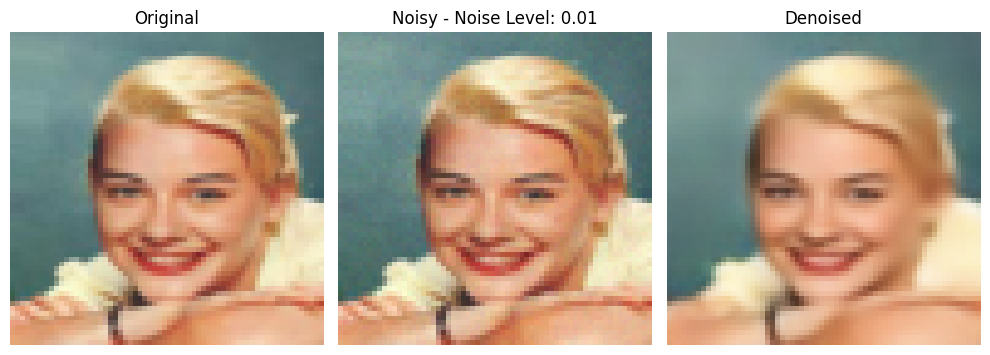

PSNR: 29.29, Noise Level: 0.02


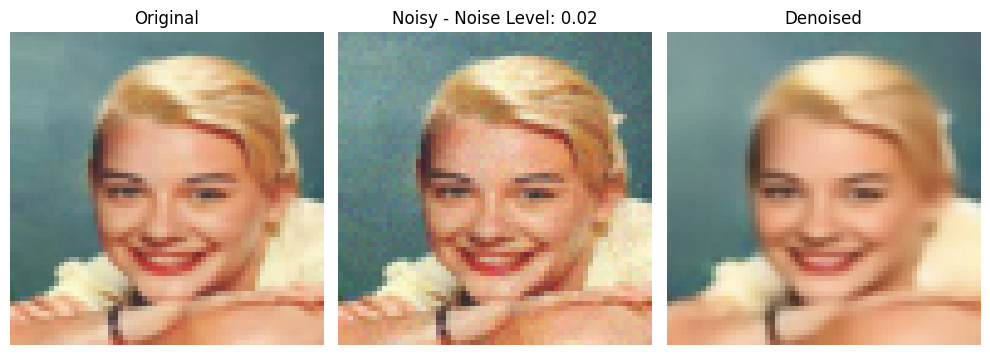

PSNR: 29.26, Noise Level: 0.03


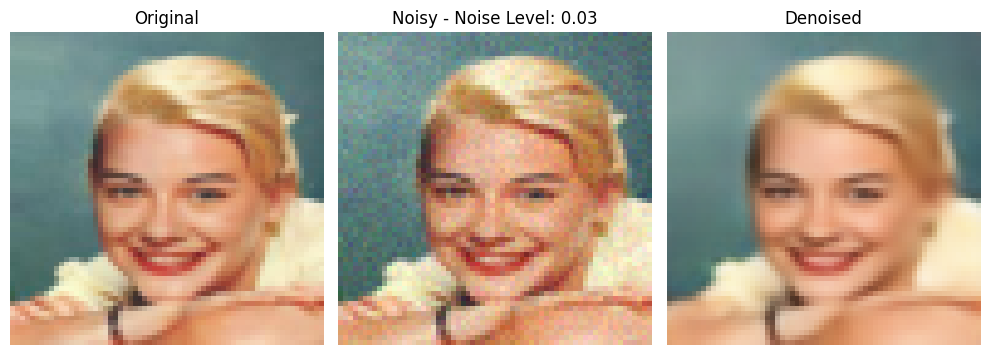

PSNR: 29.39, Noise Level: 0.04


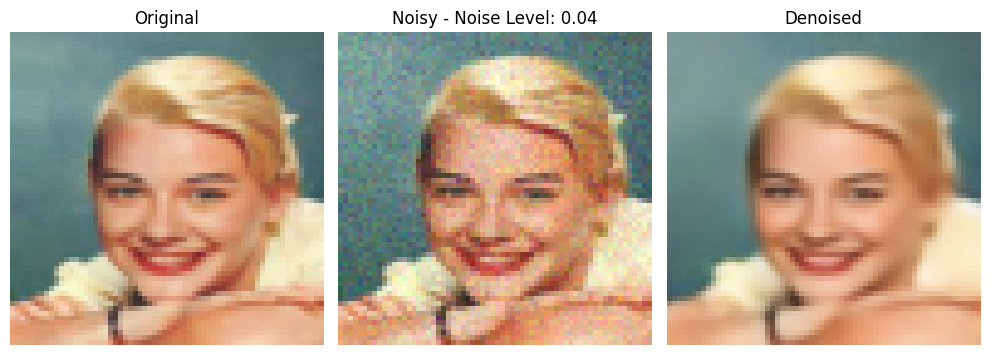

PSNR: 29.03, Noise Level: 0.05


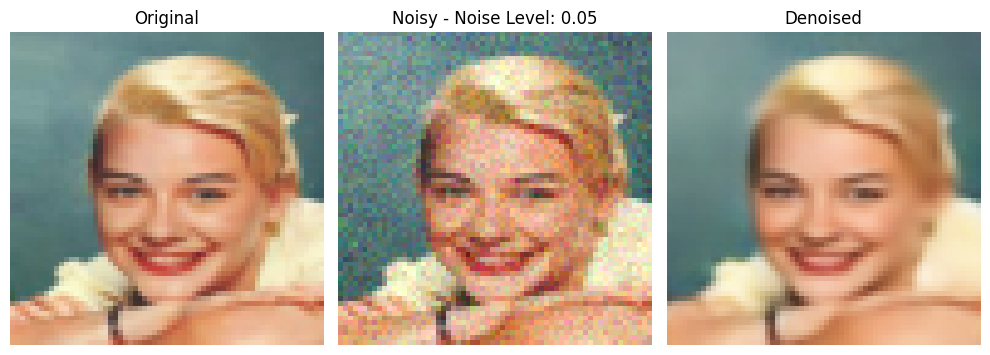

PSNR: 29.21, Noise Level: 0.06


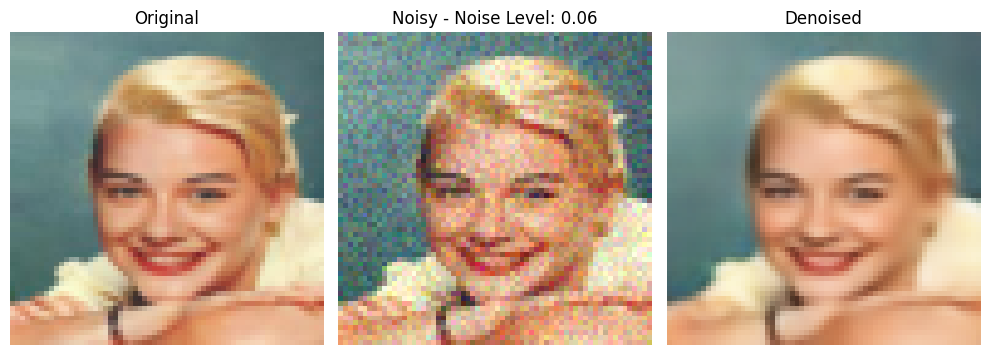

PSNR: 29.21, Noise Level: 0.07


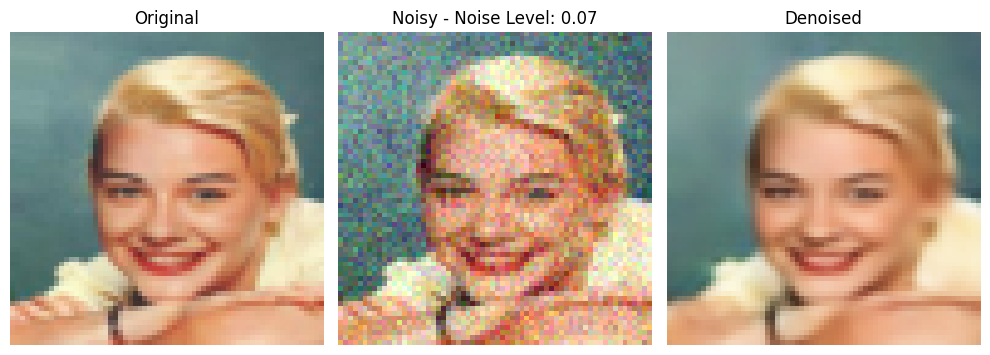

PSNR: 28.87, Noise Level: 0.08


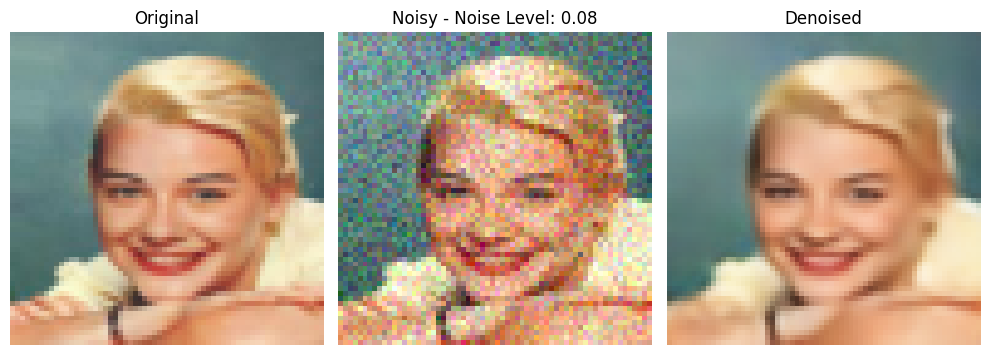

PSNR: 28.92, Noise Level: 0.09


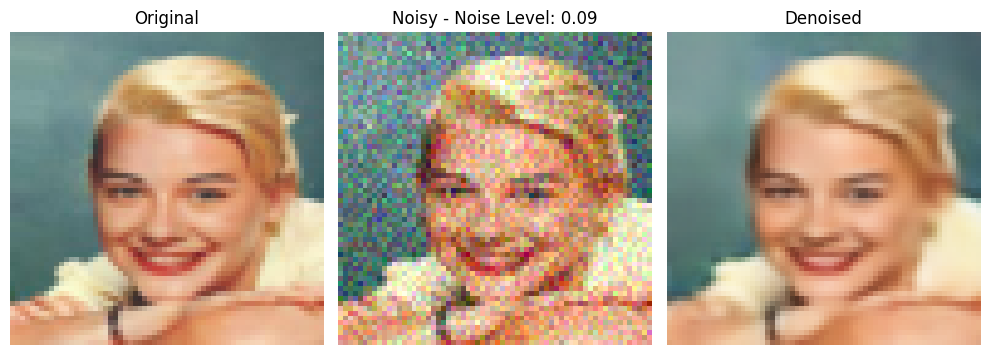

PSNR: 28.34, Noise Level: 0.1


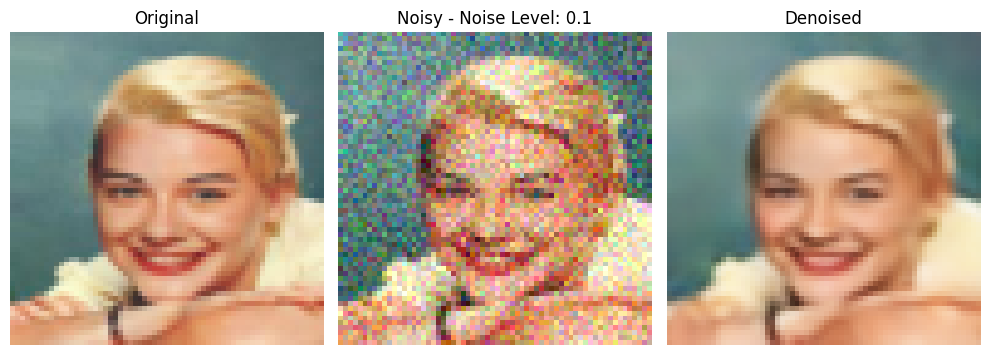

PSNR: 28.34, Noise Level: 0.11


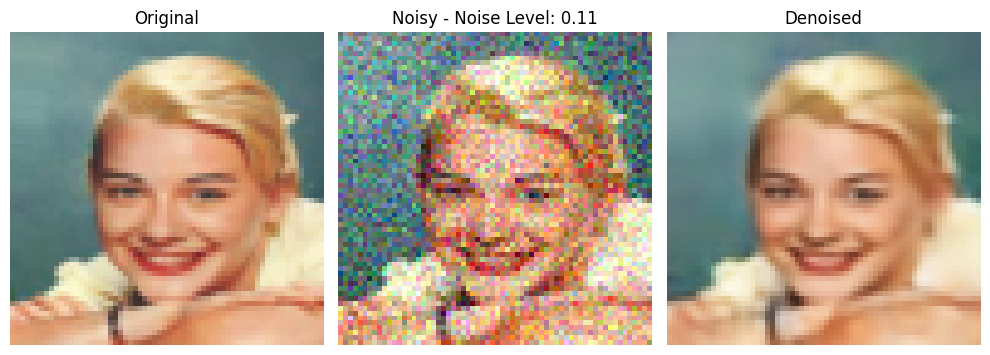

PSNR: 27.70, Noise Level: 0.12


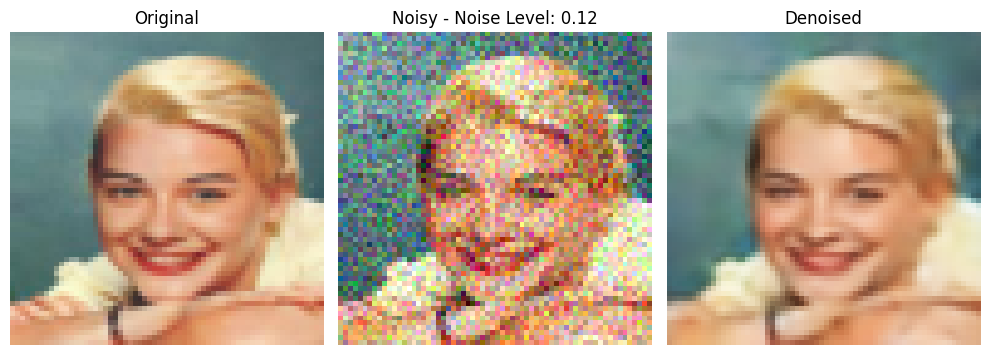

PSNR: 27.23, Noise Level: 0.13


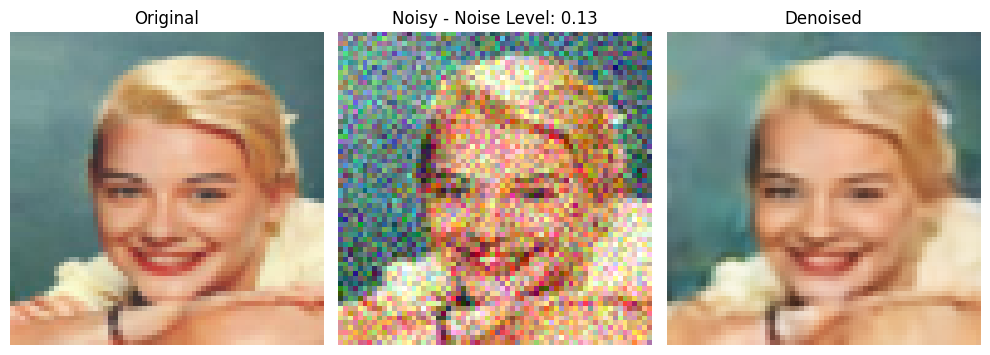

PSNR: 26.64, Noise Level: 0.14


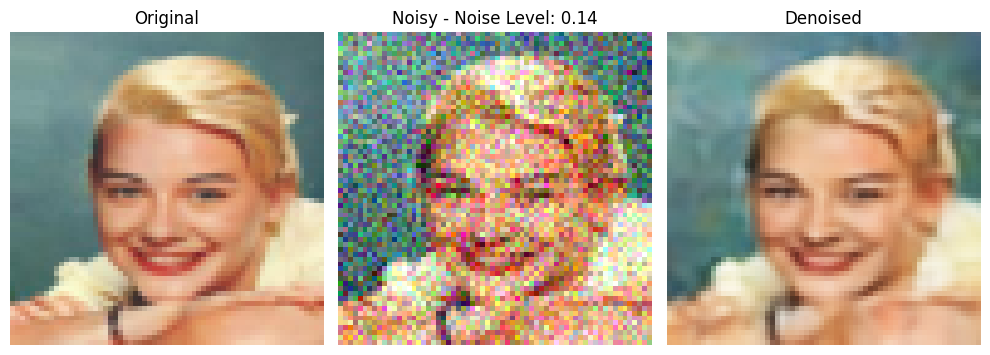

PSNR: 26.23, Noise Level: 0.15


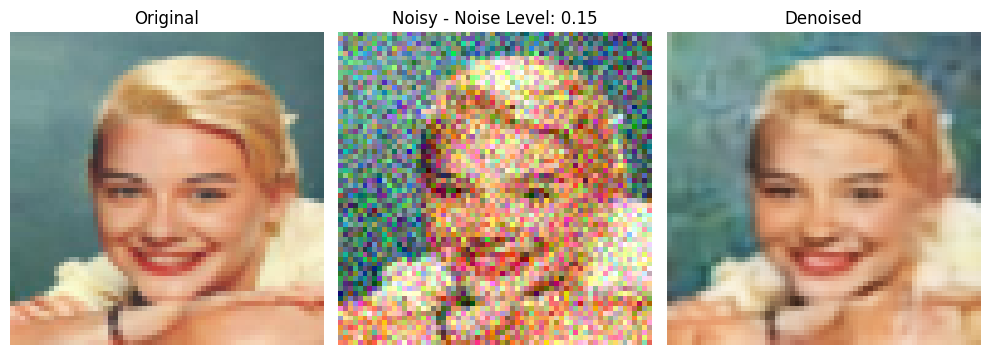

PSNR: 25.87, Noise Level: 0.16


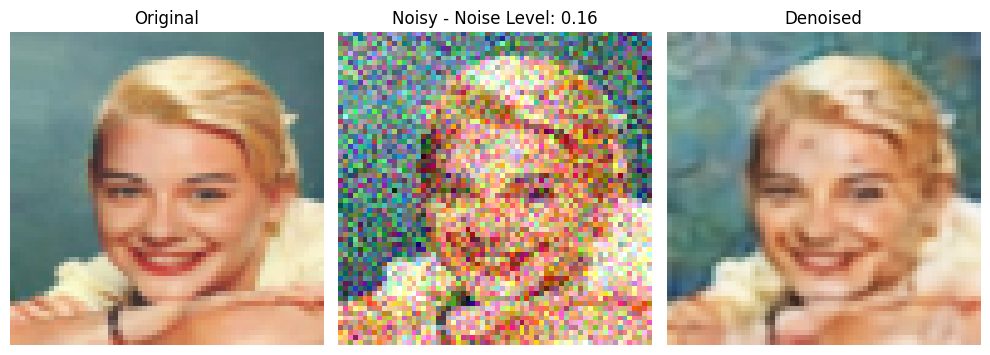

PSNR: 25.52, Noise Level: 0.17


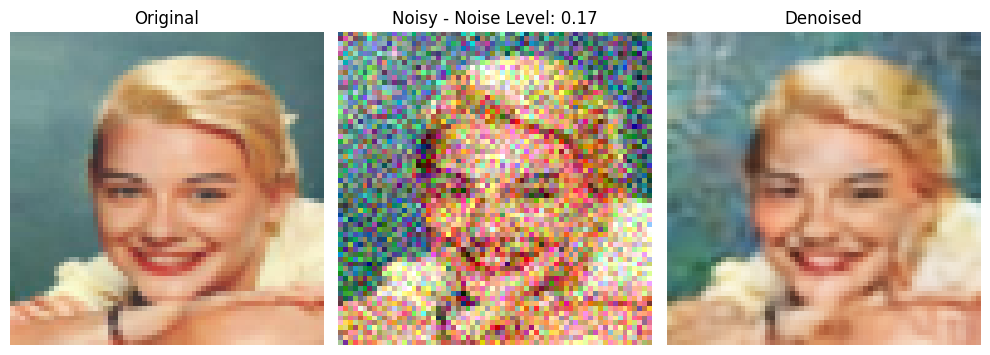

PSNR: 24.84, Noise Level: 0.18


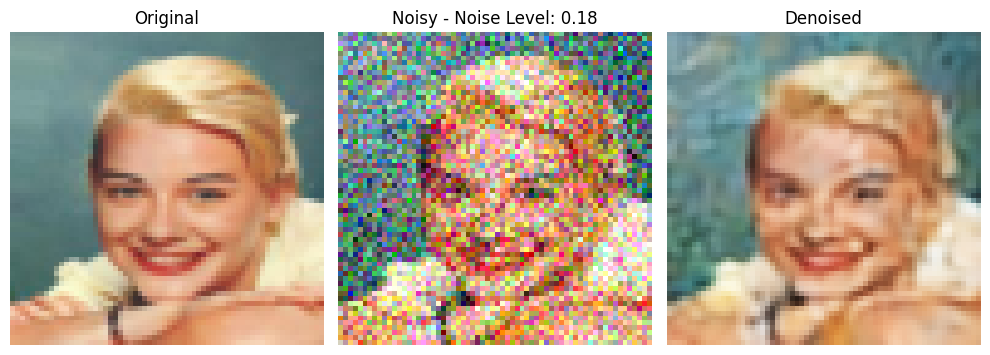

PSNR: 24.25, Noise Level: 0.19


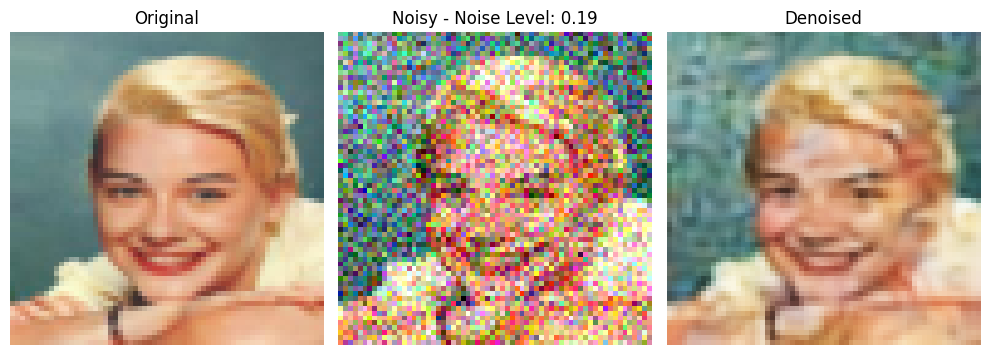

PSNR: 23.48, Noise Level: 0.2


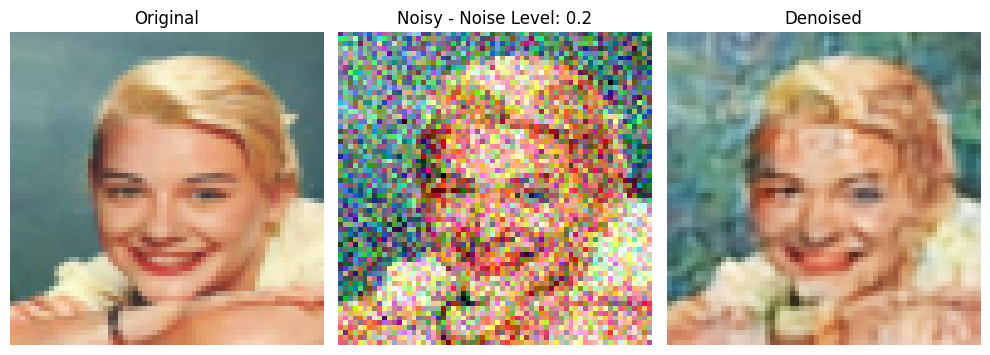

PSNR: 23.41, Noise Level: 0.21


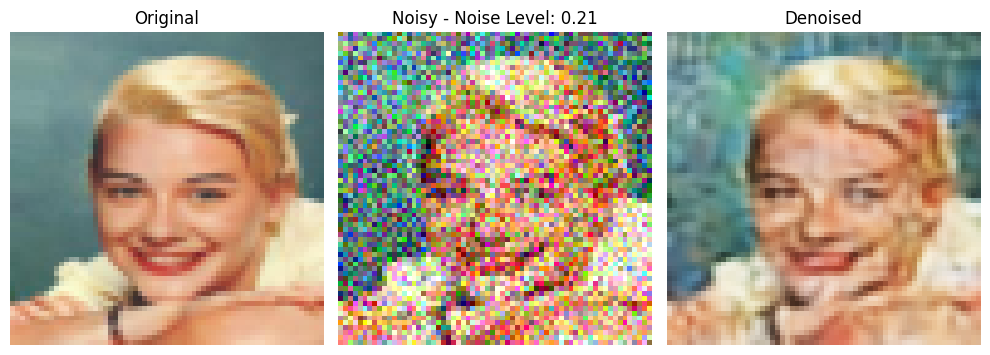

PSNR: 22.81, Noise Level: 0.22


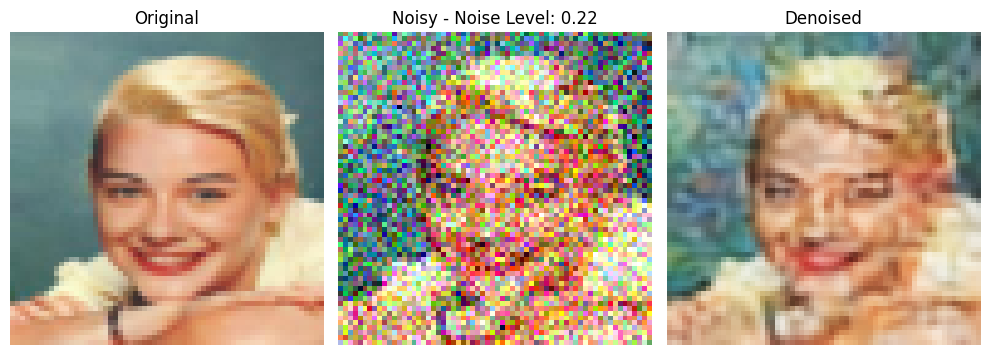

PSNR: 22.49, Noise Level: 0.23


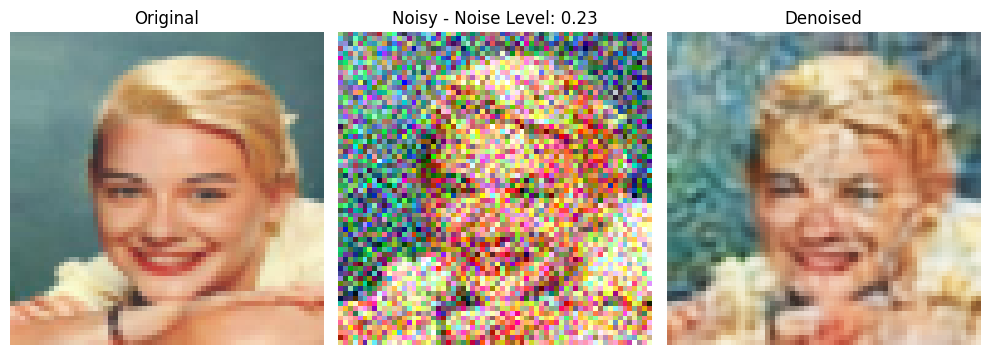

PSNR: 22.04, Noise Level: 0.24


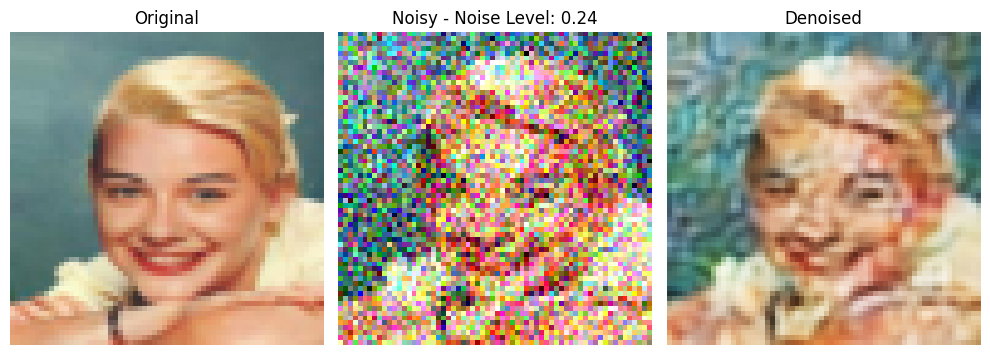

PSNR: 21.43, Noise Level: 0.25


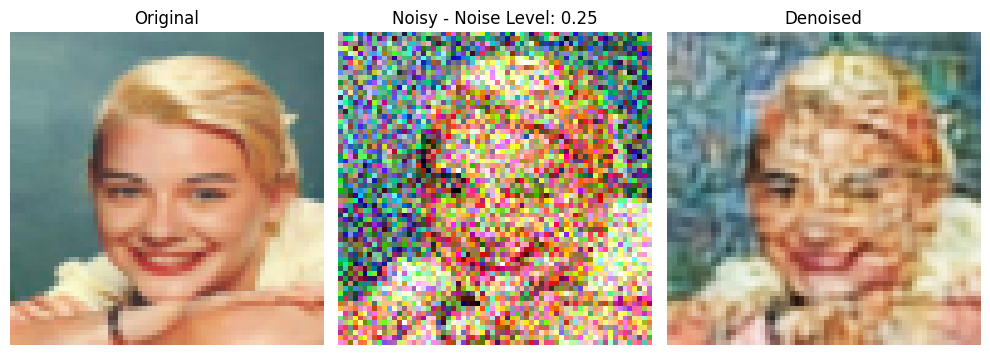

PSNR: 21.38, Noise Level: 0.26


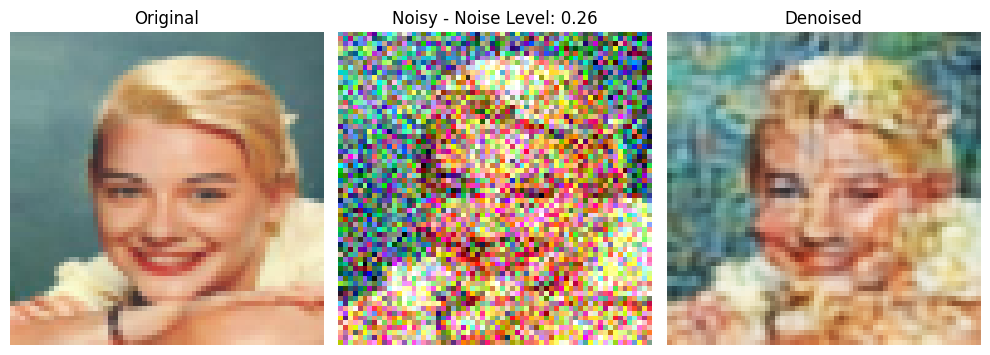

PSNR: 20.64, Noise Level: 0.27


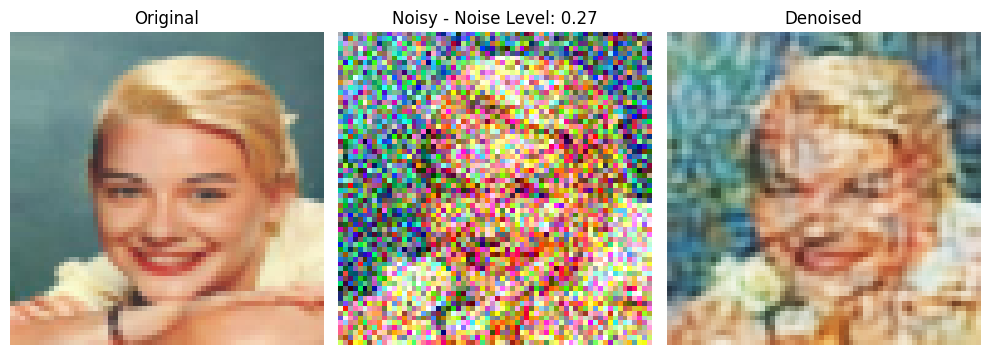

PSNR: 20.56, Noise Level: 0.28


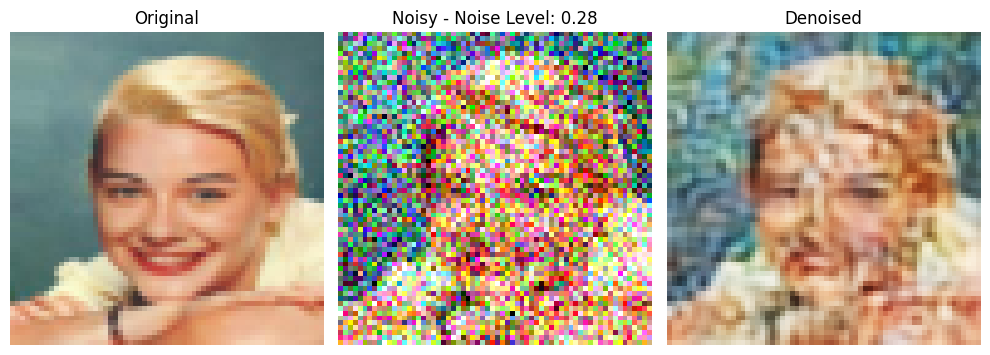

PSNR: 19.94, Noise Level: 0.29


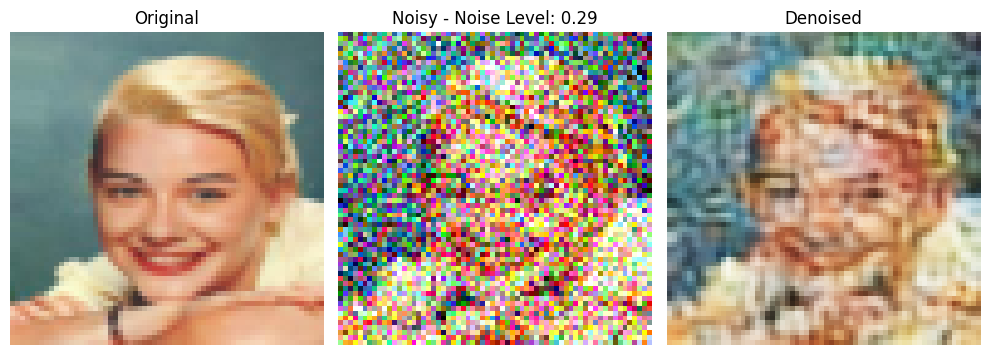

PSNR: 19.81, Noise Level: 0.3


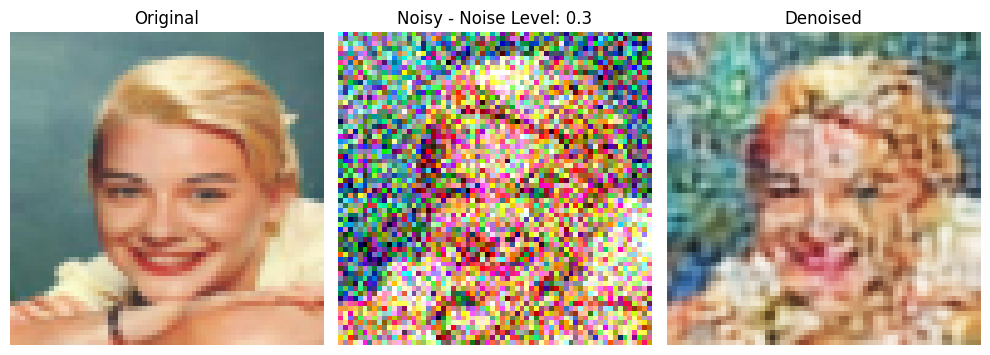

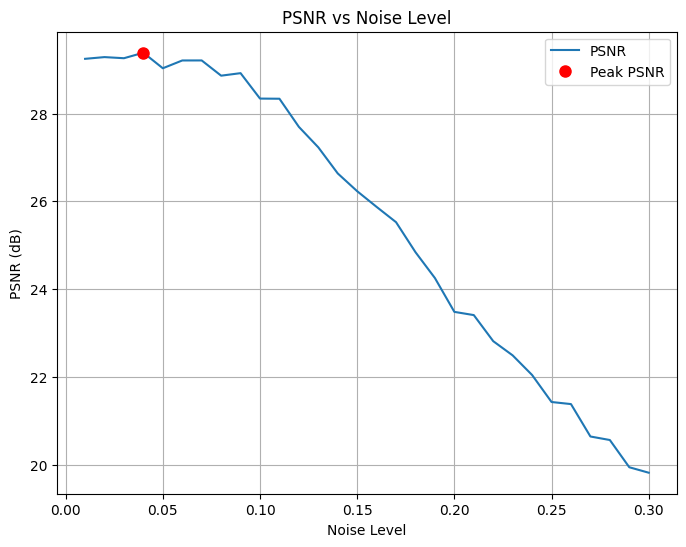

Best PSNR: 29.39 dB, Noise Level: 0.04
PSNR at 0.1 Noise Level: 28.34 dB


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from skimage import metrics
import numpy as np

# Load the pre-trained model
model = ConvAutoencoder()
model.load_state_dict(torch.load("autoencoder_model.pt"))
model.eval()

# Load and preprocess the image
image_path = "135013.jpg"
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0)

# Add noise
eps_list = np.round(np.arange(0.01, 0.31, 0.01), 2)
psnr_list = []

for eps in eps_list:
    noise = torch.randn_like(image_tensor) * eps
    noisy_image = image_tensor + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)

    # Denoise the image
    with torch.no_grad():
        denoised_image = model(noisy_image)

    # Calculate PSNR
    psnr = metrics.peak_signal_noise_ratio(image_tensor.squeeze().permute(1, 2, 0).numpy(),
                                           denoised_image.squeeze().permute(1, 2, 0).numpy(),
                                           data_range=1.0)

    psnr_list.append(psnr)

    print(f"PSNR: {psnr:.2f}, Noise Level: {eps}")

    # Convert tensors to numpy arrays and transpose
    image = image_tensor.squeeze().permute(1, 2, 0).numpy()
    noisy_image = noisy_image.squeeze().permute(1, 2, 0).numpy()
    denoised_image = denoised_image.squeeze().permute(1, 2, 0).numpy()

    # Plot the images side by side
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(image)
    axs[0].set_title("Original")
    axs[0].axis("off")
    axs[1].imshow(noisy_image)
    axs[1].set_title(f"Noisy - Noise Level: {eps}")
    axs[1].axis("off")
    axs[2].imshow(denoised_image)
    axs[2].set_title("Denoised")
    axs[2].axis("off")
    plt.tight_layout()
    plt.show()

# Plot PSNR values against noise level
plt.figure(figsize=(8, 6))
plt.plot(eps_list, psnr_list, label='PSNR')
plt.plot(eps_list[np.argmax(psnr_list)], np.max(psnr_list), 'ro', label='Peak PSNR', markersize=8)
plt.xlabel('Noise Level')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs Noise Level')
plt.legend()
plt.grid(True)
plt.show()

# Print the best PSNR achieved and corresponding noise level
best_psnr = np.max(psnr_list)
best_eps = eps_list[np.argmax(psnr_list)]
print(f"Best PSNR: {best_psnr:.2f} dB, Noise Level: {best_eps}")
print(f"PSNR at 0.1 Noise Level: {psnr_list[eps_list.tolist().index(0.1)]:.2f} dB")

In [ ]:
# Convolutional Autoencoder trained on 0.1 noise level -> PSNR = 28.56